# Imports
All dependencies may be installed using [pipenv](https://github.com/pypa/pipenv).


In [1]:
import collections
import functools
import itertools
import math
import random
import time
import multiprocessing

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sympy
import scipy

from scipy.stats import binom
from typing import Optional
from fractions import Fraction


plt.rcParams["figure.figsize"] = (15, 7)
plt.rcParams['figure.dpi']= 300

matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='serif')
matplotlib.rc('text.latex', preamble=r'\usepackage{calc}')


# Simulation Engine Core
(results are further down in this notebook)

In [2]:
A = 'A'  # shorthand for adversarial node
H = 'H'  # shorthand for honest/correct node


class LeaderSequence:
    # O(rounds) storage requirement
    # may be changed later if it is needed in constant space 
    # (e.g. by using some deterministic rng)
        
    def __init__(self, pA=None, round_robin_sequence=None, queue_len=100_000):
        self.seq = round_robin_sequence or collections.deque([], maxlen=queue_len)
        self.seqlen = 0
        self.pA = pA
        self.round_robin = round_robin_sequence is not None
        if self.round_robin:
            self.seq = self.seq.replace(" ",  "")
            self.n = len(self.seq)
            self.f = len(self.seq.replace("H",  ""))
    
    def __getitem__(self, key):
        if self.round_robin:
            return self.seq[key % len(self.seq)]
        
        while key >= self.seqlen:
            self.seq.append(A if random.random() < self.pA else H)
            self.seqlen += 1
                   
        d = key - (self.seqlen - len(self.seq))
        assert d >= 0
        return self.seq[d]
        

def simulate(alpha, delta_net, delta_vdf, num_rounds, pA=None, round_robin_sequence=None):
    """ computes the adversaries advantages during a period of 'num_rounds' rounds
        pass either pA (the probability of selecting an adversary, f/n) or 
        a round_robin_sequence for the simulation
    """    
    assert pA is not None or round_robin_sequence is not None
    assert not (pA is not None and round_robin_sequence is not None)

    delta_vdf_h = delta_vdf
    delta_vdf_a = delta_vdf // alpha if delta_vdf % alpha == 0 else Fraction(delta_vdf, alpha)

    # handles both round robin and random draw leader selection
    # generated new leaders on first access
    leaders = LeaderSequence(pA, round_robin_sequence)
        
    # rH, rHs, rA... number of rounds completed by the (fastest) correct node and the adversary
    # tH, tHs, tA... current time for the (fastest) correct node and the adversary
    rH, rHs, rA = 0, 0, 0
    tH, tHs, tA = 0, 0, 0
    TH, THs, TA = [0], [0], [0]
        
    advantage = 0
    advantages = []
    
    t_frame_start = 0
    t_now = 0
    
    tH_next  = 0           if leaders[0] == H else delta_vdf_h
    tHs_next = delta_net   if leaders[0] == H else delta_vdf_h
    tA_next  = delta_vdf_a if leaders[0] == H else 0

    while rH < num_rounds:
        # adversary makes a step, and advantage increases by 1
        if tA_next <= tH_next: 
            rA += 1
            TA.append(tA_next)
            t_next = tA_next
            tA = tA_next
            if leaders[rA] == H:
                tA_next += delta_vdf_a
            new_advantage = advantage + 1
                            
        # fastest honest node makes a step
        else:
            rH += 1
            TH.append(tH_next)            
            THs.append(tHs_next)

            # reset adversary if overtaken by correct node
            if rH > rA:                
                tA_next = tH_next
            
            t_next = tH_next
            tH = tH_next
            if leaders[rH] == H:
                tH_next = tHs_next
                tHs_next += delta_net
            else:
                tH_next += delta_vdf_h
                tHs_next += delta_vdf_h
            
            new_advantage = advantage - 1                
       
        if advantage != new_advantage:
            if t_frame_start < t_next:
                advantages.append((t_frame_start, t_next, advantage))
            advantage = new_advantage   
            t_frame_start = t_next
                    
        t_now = t_next
   
    return TH, THs, TA, leaders, advantages


def simulate_fast(pA, alpha, delta_net, delta_vdf, num_rounds):
    delta_vdf_h = delta_vdf
    delta_vdf_a = delta_vdf // alpha if delta_vdf % alpha == 0 else delta_vdf / alpha
    
    leaders = LeaderSequence(pA)
        
    # rH, rHs, rA... number of rounds completed by the (fastest) correct node and the adversary
    # tH, tHs, tA... current time for the (fastest) correct node and the adversary
    rH, rHs, rA = 0, 0, 0
    tH, tHs, tA = 0, 0, 0
        
    advantage = 0
    advantage_durations = [0]
    
    t_frame_start = 0
    
    tH_next  = 0           if leaders[0] == H else delta_vdf_h
    tHs_next = delta_net   if leaders[0] == H else delta_vdf_h
    tA_next  = delta_vdf_a if leaders[0] == H else 0

    while rH < num_rounds:

        # adversary makes a step, and advantage increases by 1
        if tA_next <= tH_next: 
            rA += 1
            t_next = tA_next
            tA = tA_next
            if leaders[rA] == H:
                tA_next += delta_vdf_a
            new_advantage = advantage + 1
                            
        # fastest honest node makes a step
        else:
            rH += 1
            # reset adversary if overtaken by correct node
            if rH > rA:                
                tA_next = tH_next
            
            t_next = tH_next
            tH = tH_next
            if leaders[rH] == H:
                tH_next = tHs_next
                tHs_next += delta_net
            else:
                tH_next += delta_vdf_h
                tHs_next += delta_vdf_h
            
            new_advantage = advantage - 1
            
        if advantage != new_advantage:
            if t_frame_start < t_next:
                while len(advantage_durations) <= advantage:
                    advantage_durations.append(0)
                advantage_durations[advantage] += t_next - t_frame_start
            advantage = new_advantage   
            t_frame_start = t_next
                       
    return advantage_durations


In [3]:
def simulate_covert(alpha, delta_net, delta_vdf, num_rounds, pA=None, round_robin_sequence=None):
    """ computes the adversaries advantages during a period of 'num_rounds' rounds
        pass either pA (the probability of selecting an adversary, f/n) or 
        a round_robin_sequence for the simulation
    """    
    assert pA is not None or round_robin_sequence is not None
    assert not (pA is not None and round_robin_sequence is not None)

    delta_vdf_h = delta_vdf
    delta_vdf_a = delta_vdf // alpha if delta_vdf % alpha == 0 else Fraction(delta_vdf, alpha)

    # handles both round robin and random draw leader selection
    # generated new leaders on first access
    leaders = LeaderSequence(pA, round_robin_sequence)
    
    rA, tA = 0, 0
    TH, THs, TA = [0], [0], [0]
        
    tH_next  = 0           if leaders[0] == H else delta_net
    tHs_next = delta_net
    tA_next  = delta_vdf_a if leaders[0] == H else 0

    t_frame_start = 0
    advantage = 0
    advantages = []
    
    tH = 0
    rH = 0
       
    for rHs in range(num_rounds):        
        # honest leader immediately complete round rHs
        if leaders[rHs] == H:
            rH += 1
            TH.append(tH)        
            if t_frame_start != tH:
                advantages.append((t_frame_start, tH, advantage))
                t_frame_start = tH
            advantage -= 1
        
        # check and reset adversary if overtaken by honest leader
        if rA < rH:
            rA = rH
            tA = tH
            TA.append(tA)
            if t_frame_start != tA:
                advantages.append((t_frame_start, tA, advantage))
                t_frame_start = tA
            advantage = 0
        
        # advance the adversary as far as possible
        while (tA_next := tA if leaders[rA] == A else tA + delta_vdf_a) <= tH:
            rA += 1
            TA.append(tA)
            tA = tA_next
            if t_frame_start != tA:
                advantages.append((t_frame_start, tA, advantage))
                t_frame_start = tA
            advantage += 1
        
        # each honest node completes round rHs after at most delta_net seconds
        # also the leader if it did not already
        tH += delta_net
        THs.append(tH)
        if leaders[rHs] == A: 
            rH += 1
            TH.append(tH)
            if t_frame_start != tH:
                advantages.append((t_frame_start, tH, advantage))
                t_frame_start = tH
            advantage -= 1
        
    return TH, THs, TA, leaders, advantages
    

In [4]:
def simulate_covert_fast(pA, alpha, delta_net, delta_vdf, num_rounds):
    delta_vdf_a = delta_vdf // alpha if delta_vdf % alpha == 0 else delta_vdf / alpha
    leaders = LeaderSequence(pA)
    
    rA, tA = 0, 0
        
    tH_next  = 0           if leaders[0] == H else delta_net
    tHs_next = delta_net
    tA_next  = delta_vdf_a if leaders[0] == H else 0

    t_frame_start = 0
    advantage = 0
    advantage_durations = [0]
    
    tH = 0
    rH = 0
       
    for rHs in range(num_rounds):        
        # honest leader immediately complete round rHs
        if leaders[rHs] == H:
            rH += 1    
            if t_frame_start != tH:
                while len(advantage_durations) <= advantage:
                    advantage_durations.append(0)
                advantage_durations[advantage] += tH - t_frame_start
                t_frame_start = tH
            advantage -= 1
        
        # check and reset adversary if overtaken by honest leader
        if rA < rH:
            rA = rH
            tA = tH
            if t_frame_start != tA:
                while len(advantage_durations) <= advantage:
                    advantage_durations.append(0)
                advantage_durations[advantage] += tA - t_frame_start
                t_frame_start = tA
            advantage = 0
        
        # advance the adversary as far as possible
        while (tA_next := tA if leaders[rA] == A else tA + delta_vdf_a) <= tH:
            rA += 1
            tA = tA_next
            if t_frame_start != tA:
                while len(advantage_durations) <= advantage:
                    advantage_durations.append(0)
                advantage_durations[advantage] += tA - t_frame_start
                t_frame_start = tA
            advantage += 1
        
        # each honest node completes round rHs after at most delta_net seconds
        # also the leader if it did not already
        tH += delta_net
        if leaders[rHs] == A: 
            rH += 1
            if t_frame_start != tH:
                while len(advantage_durations) <= advantage:
                    advantage_durations.append(0)
                advantage_durations[advantage] += tH - t_frame_start
                t_frame_start = tH
            advantage -= 1
        
    return advantage_durations
    

In [5]:
def worst_case_round_robin_sequence(n, f):
    return A * (f) + H * (n - f)

def worst_case_round_robin_sequences(n, f):
    S = worst_case_round_robin_sequence(n, f)
    return [S[-i:] + S[:-i] for i in range(n)]

def round_robin_sequences(n, f):
    def expand(num_repr):
        return ''.join([A if (num_repr & (1 << i)) else H for i in range(n)])
    
    def iterator():
        v = (1 << f) - 1
        while v < (1 << n):
            yield expand(v)
            t = (v | (v - 1)) + 1
            v = t | ((((t & -t) // (v & -v)) >> 1) - 1)
    
    return iterator()

def random_round_robin_sequence(n, f):
    seq = [A if i < f else H for i in range(n)]
    random.shuffle(seq)
    return "".join(seq)

def number_of_round_robin_sequences(n, f):
    return math.factorial(n) // (math.factorial(f) * math.factorial(n -f))
    

In [6]:
def advantage_sum(advantages):
    sums = [0] * (max(a for _,_,a in advantages) + 1)
    for t1, t2, a in advantages:
        sums[a] += t2 - t1
    return sums
        
def advantage_distribution(advantages, cumulative=False):
    sums = advantage_sum(advantages)
    total = sum(sums)
    if cumulative:
        for i in range(len(sums) - 1, 0, -1):
            sums[i - 1] += sums[i]   
    return [s / total for s in sums]
        
def advantage_distribution_from_durations(advantage_durations, cumulative=False):
    total = sum(advantage_durations)
    copy = advantage_durations[:]
    if cumulative:
        for i in range(len(advantage_durations) - 1, 0, -1):
            copy[i - 1] += copy[i]
    return [s / total for s in copy]

def unpredictability_simulation_get_distribution(params):
    covert, num_rounds, pA, alpha, delta_net, delta_vdf, *_ = params
    if covert:
        r = simulate_covert_fast(pA, alpha, delta_net, delta_vdf, num_rounds)
    else:
        r = simulate_fast(pA, alpha, delta_net, delta_vdf, num_rounds)
            
    return advantage_distribution_from_durations(r, cumulative=True)


## Main Simulation Execution / Rendering Source

In [7]:
# global configuration for the number of rounds the simulation should run
# 10**10 rounds are used for the results in the paper, 10**6 is a good first quick iterative exploration
DEFAULT_NUM_ROUNDS = 10**10

SAVE_FIGURES_AS_PDFS = False


In [8]:
def fig_unpredictability_random_draw(
    parameters, 
    covert, 
    figname="undefined",
    num_rounds=DEFAULT_NUM_ROUNDS, 
    figsize=(6, 3), 
    ylim=1e-6,    
    loc='upper right',
    bbox_to_anchor=(1.0, 1.012),
):   
    tstart = time.time()
    with multiprocessing.Pool(len(parameters)) as p:
        advantage_distributions = p.map(
            unpredictability_simulation_get_distribution, 
            [(covert, num_rounds, *p) for p in parameters]
        )    
    tend = time.time()
    print(f"simulation completed after {tend - tstart} seconds")
    
    def all_equal(i):
        v = parameters[0][i]
        for w in parameters[1:]:
            if w[i] != v:
                return False
        return True
    
    add_pA_label        = not all_equal(0)
    add_alpha_label     = not all_equal(1)
    add_delta_net_label = not all_equal(2)
    add_delta_vdf_label = not all_equal(3)
    
    fig, ax = plt.subplots(figsize=figsize)
    for dist, (pA, alpha, delta_net, delta_vdf, style, color) in zip(advantage_distributions, parameters):
        label = ""
        for do_add, label_str in zip(
            [add_pA_label, add_alpha_label, add_delta_net_label, add_delta_vdf_label],
            [
                f"\\makebox[17.0mm][l]{{ $ p_A             = {pA:.2f}       $ }}",
                f"\\makebox[14.0mm][l]{{ $ \\alpha         = {float(alpha)} $ }}",
                f"\\makebox[32.0mm][l]{{ $ \\Delta_{{NET}} = {delta_net}    $ }}",
                f"\\makebox[32.0mm][l]{{ $ \\Delta_{{VDF}} = {delta_vdf}    $ }}",
            ]
        ):
            if do_add:
                if label:
                    label = label[:-2] + ", }"
                label += label_str
        ax.plot(range(len(dist)), dist, style, color=color, label=label)

    # plot axis labels and title
    ax.set(
        xlabel='number of rounds to predict', 
        ylabel='probability of successful prediction',
    )
    ax.grid(axis="y", linestyle=":")

    plt.xlim(-0.5, 82)
    plt.ylim(ylim, 1.3)
    plt.yscale("log")
    
    plt.legend(loc=loc, bbox_to_anchor=bbox_to_anchor)
    if SAVE_FIGURES_AS_PDFS:
        plt.savefig(
            f"../paper/figures/sim-{figname}-{num_rounds}.pdf", 
            bbox_inches="tight"
        )
    plt.show() 
    

# RandRunner-RS Unpredictability $ \left( \Delta_{NET } / \Delta_{VDF} = 1/10 \right) $
### A. Byzantine Adversary Model

simulation completed after 12111.341977119446 seconds


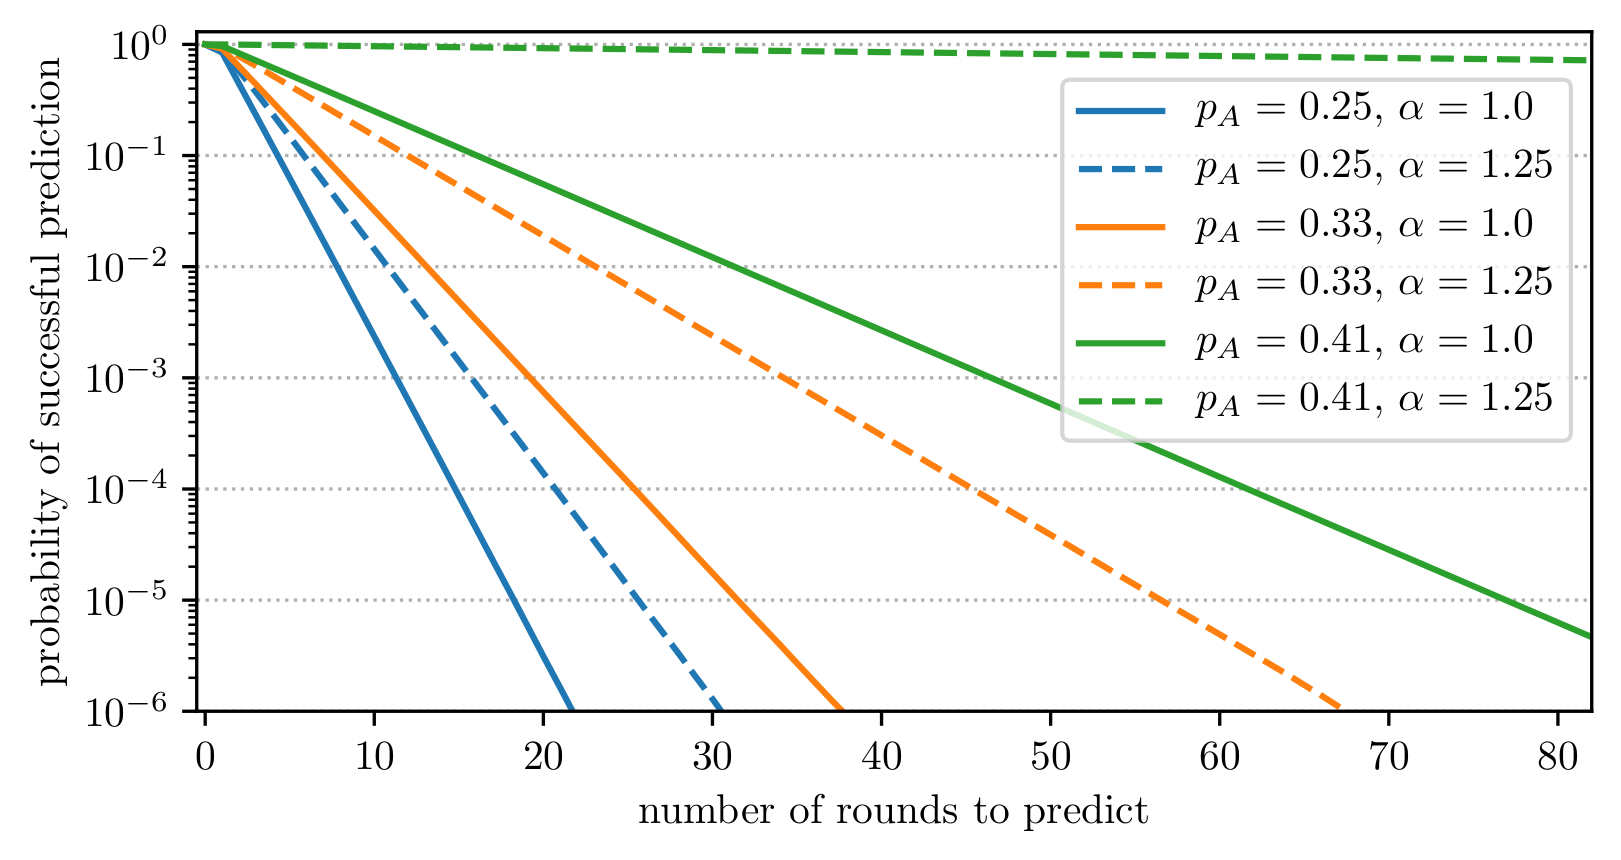

In [9]:
fig_unpredictability_random_draw(
    figname="main",
    parameters=[    
        (0.25, 1.00, 1, 10, "-",  "C0"),
        (0.25, 1.25, 1, 10, "--", "C0"),
        (0.33, 1.00, 1, 10, "-",  "C1"),
        (0.33, 1.25, 1, 10, "--", "C1"),
        (0.41, 1.00, 1, 10, "-",  "C2"),        
        (0.41, 1.25, 1, 10, "--", "C2"),        
    ],
    covert=False,
    loc='upper right',
    bbox_to_anchor=(1.0, 0.96),
)


### B. Covert Adversary Model 

simulation completed after 14595.165538787842 seconds


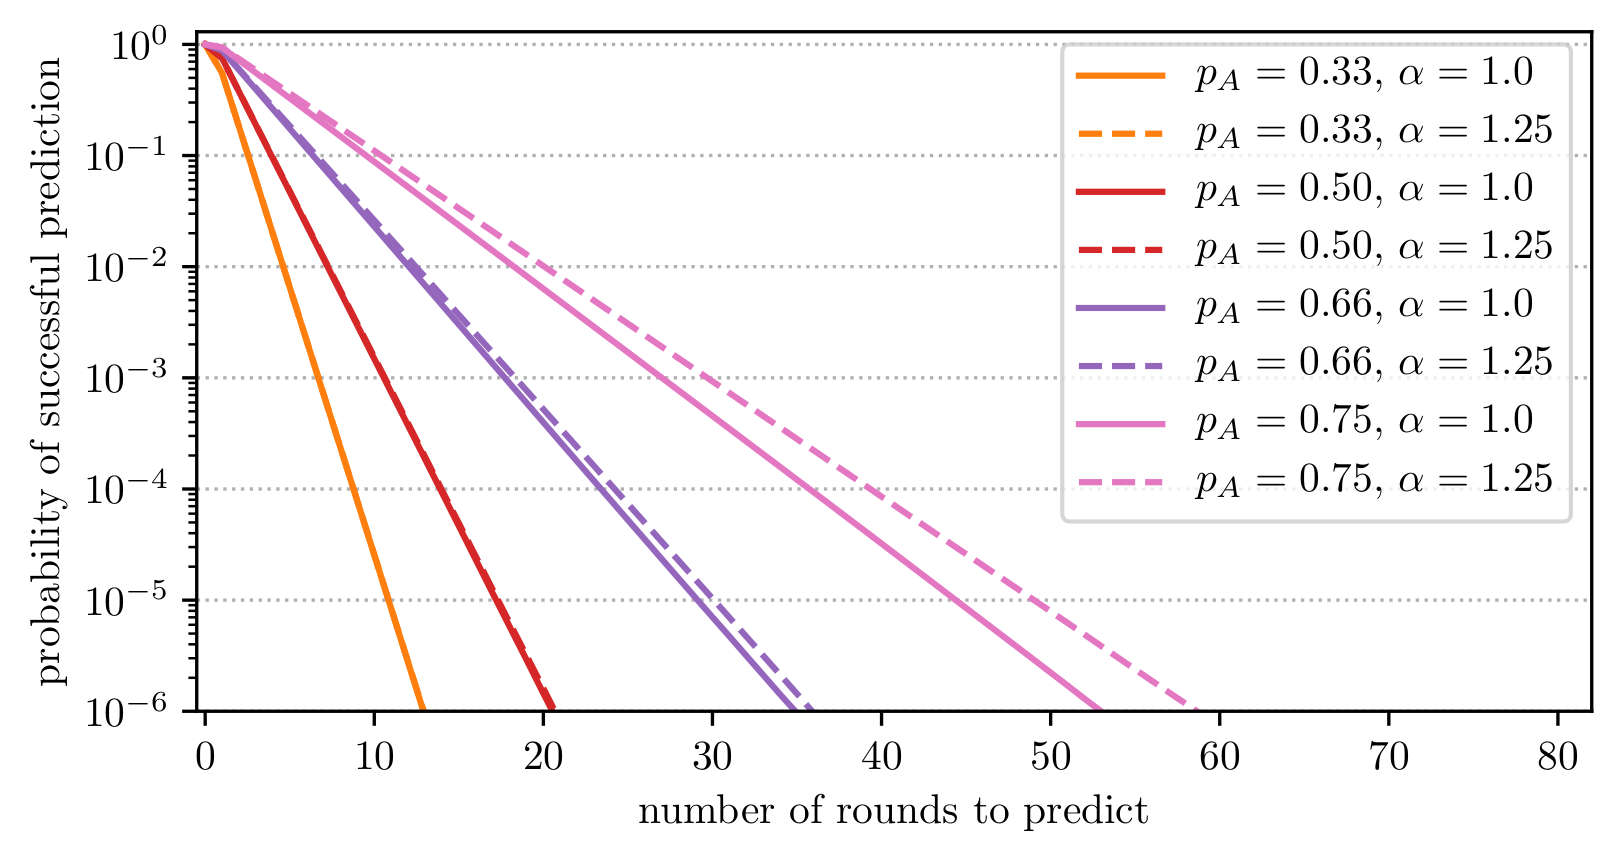

In [10]:
fig_unpredictability_random_draw(
    figname="main-covert",
    parameters=[    
        (0.33, 1.00, 1, 10, "-",  "C1"),
        (0.33, 1.25, 1, 10, "--", "C1"),
        (0.50, 1.00, 1, 10, "-",  "C3"),        
        (0.50, 1.25, 1, 10, "--", "C3"),
        (0.66, 1.00, 1, 10, "-",  "C4"),        
        (0.66, 1.25, 1, 10, "--", "C4"),
        (0.75, 1.00, 1, 10, "-",  "C6"),        
        (0.75, 1.25, 1, 10, "--", "C6"),
    ],
    covert=True,
)


## Impact of changing $ \Delta_{VDF} $ for different adversarial strengths $ p_A $  ($ \alpha=1 $, $ \Delta_{NET} = 1 $)

### A. Byzantine Adversary Model

simulation completed after 12349.659538269043 seconds


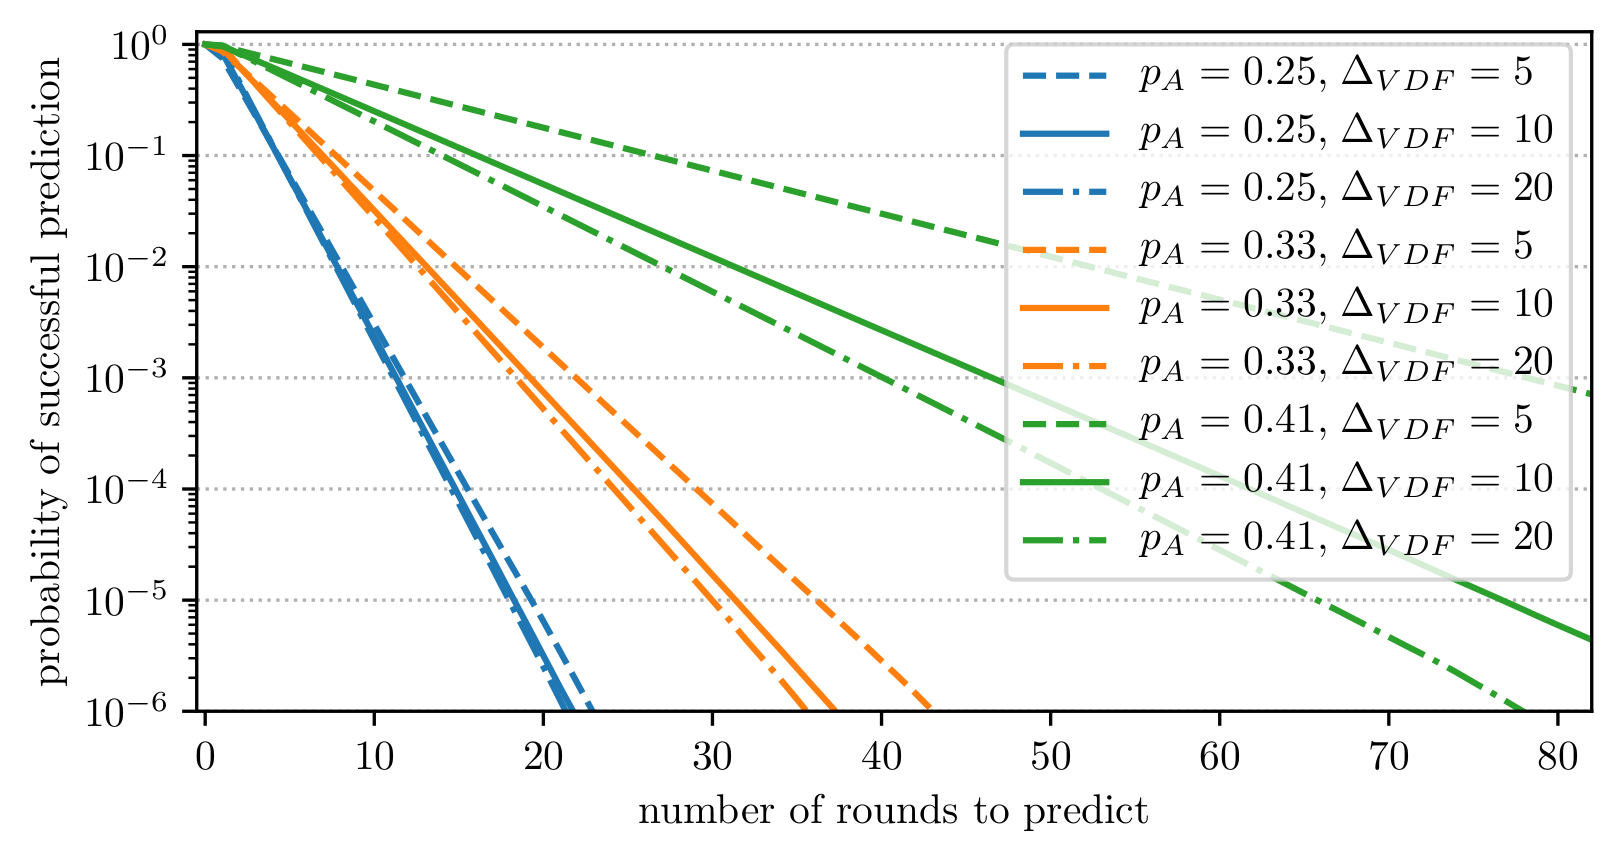

In [11]:
fig_unpredictability_random_draw(
    figname="delta-vdf",
    parameters=[    
        (0.25, 1, 1,  5, "--", "C0"),
        (0.25, 1, 1, 10, "-",  "C0"),
        (0.25, 1, 1, 20, "-.", "C0"), 
        (0.33, 1, 1,  5, "--", "C1"),
        (0.33, 1, 1, 10, "-",  "C1"),
        (0.33, 1, 1, 20, "-.", "C1"),          
        (0.41, 1, 1,  5, "--", "C2"),
        (0.41, 1, 1, 10, "-",  "C2"),
        (0.41, 1, 1, 20, "-.", "C2"), 
    ],
    covert=False, 
)


### B. Convert Adversary Model

simulation completed after 15845.042524814606 seconds


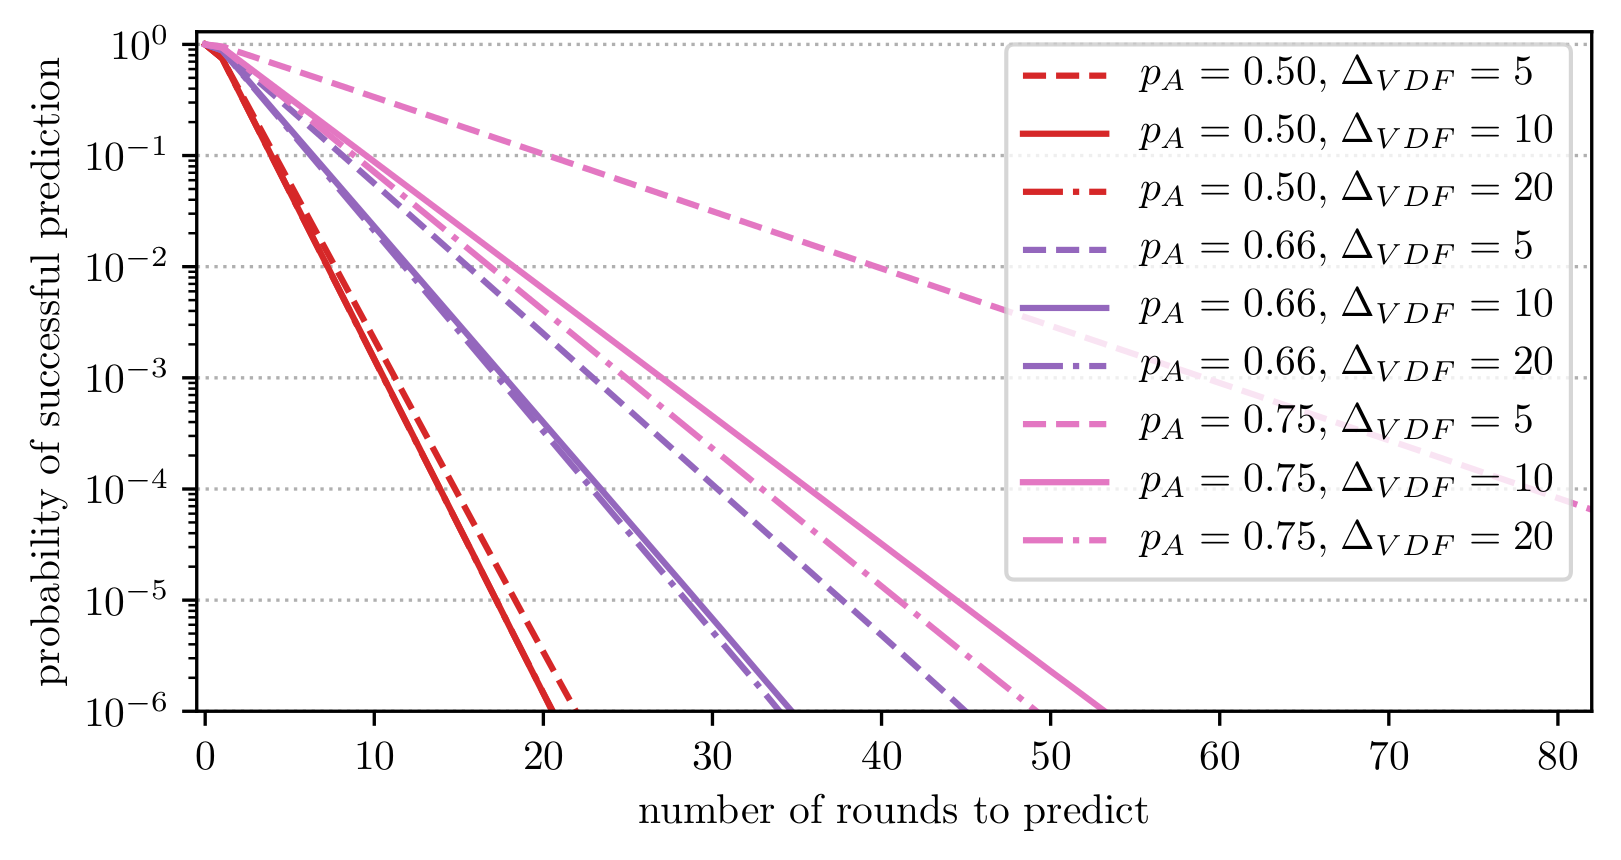

In [12]:
fig_unpredictability_random_draw(
    figname="delta-vdf-covert",
    parameters=[    
        (0.50, 1, 1,  5, "--", "C3"),
        (0.50, 1, 1, 10, "-",  "C3"),
        (0.50, 1, 1, 20, "-.", "C3"),
        (0.66, 1, 1,  5, "--", "C4"),
        (0.66, 1, 1, 10, "-",  "C4"),
        (0.66, 1, 1, 20, "-.", "C4"),        
        (0.75, 1, 1,  5, "--", "C6"),
        (0.75, 1, 1, 10, "-",  "C6"),
        (0.75, 1, 1, 20, "-.", "C6"),
    ],
    covert=True, 
)


## Impact of changing $ \Delta_{VDF} $, for different advantages $ \alpha $ ($ p_A = 0.33 $, $ \Delta_{NET} = 1 $)
### A. Byzantine Adversary Model

simulation completed after 13911.263023614883 seconds


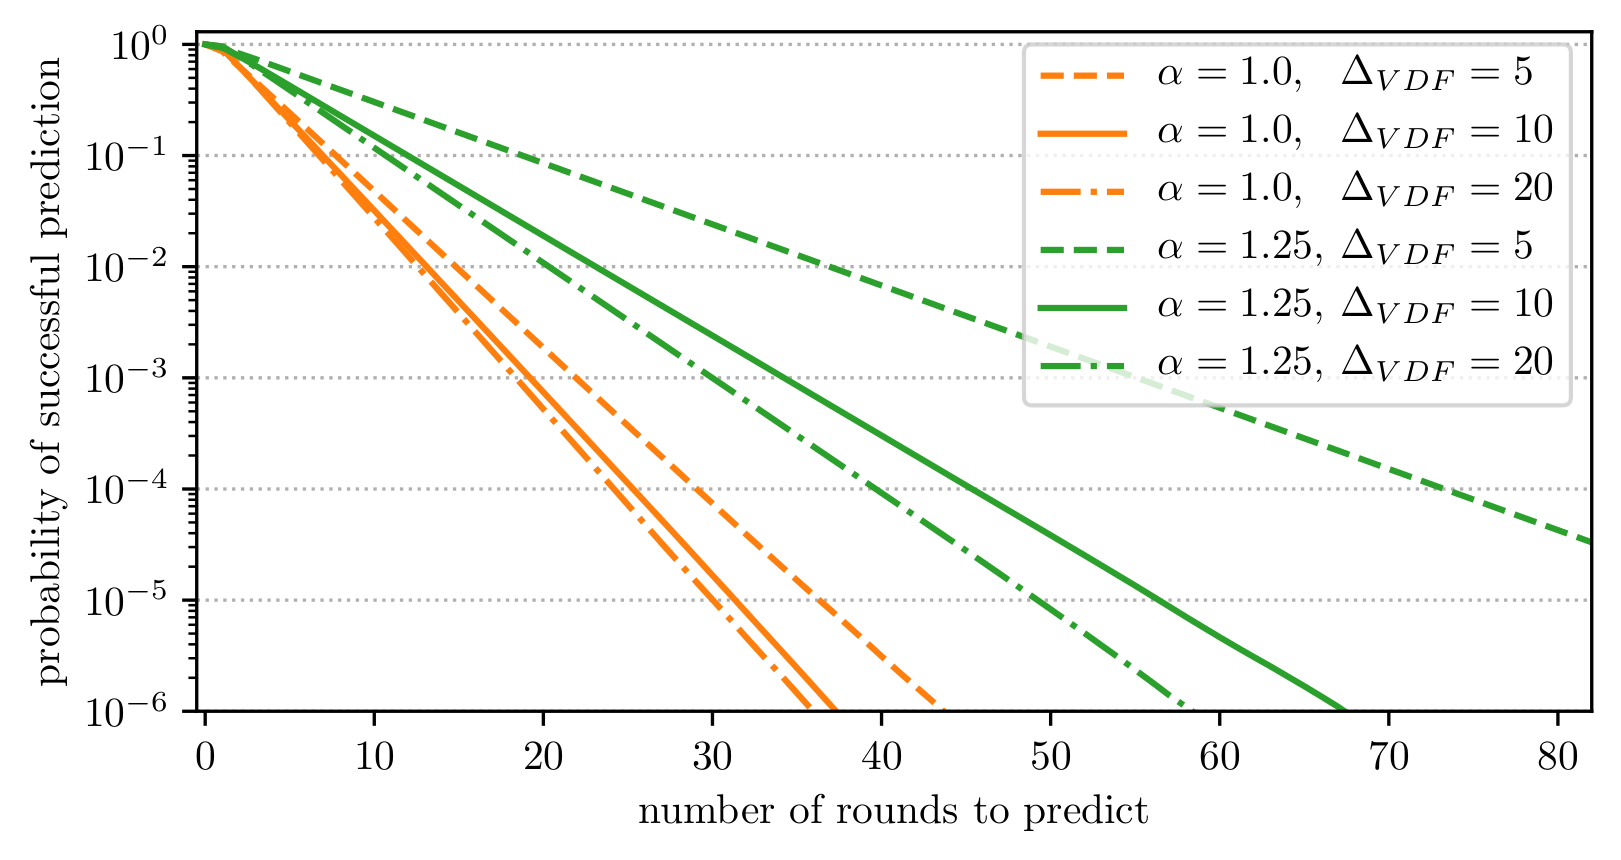

In [13]:
fig_unpredictability_random_draw(
    figname="pA",
    parameters=[    
        (0.33, 1, 1,  5, "--", "C1"),
        (0.33, 1, 1, 10, "-",  "C1"),
        (0.33, 1, 1, 20, "-.", "C1"),        
        (0.33, 1.25, 1,  5, "--", "C2"),
        (0.33, 1.25, 1, 10, "-",  "C2"),
        (0.33, 1.25, 1, 20, "-.", "C2"), 
    ],
    covert=False,
)


### B. Covert Adversary Model

simulation completed after 16830.989010095596 seconds


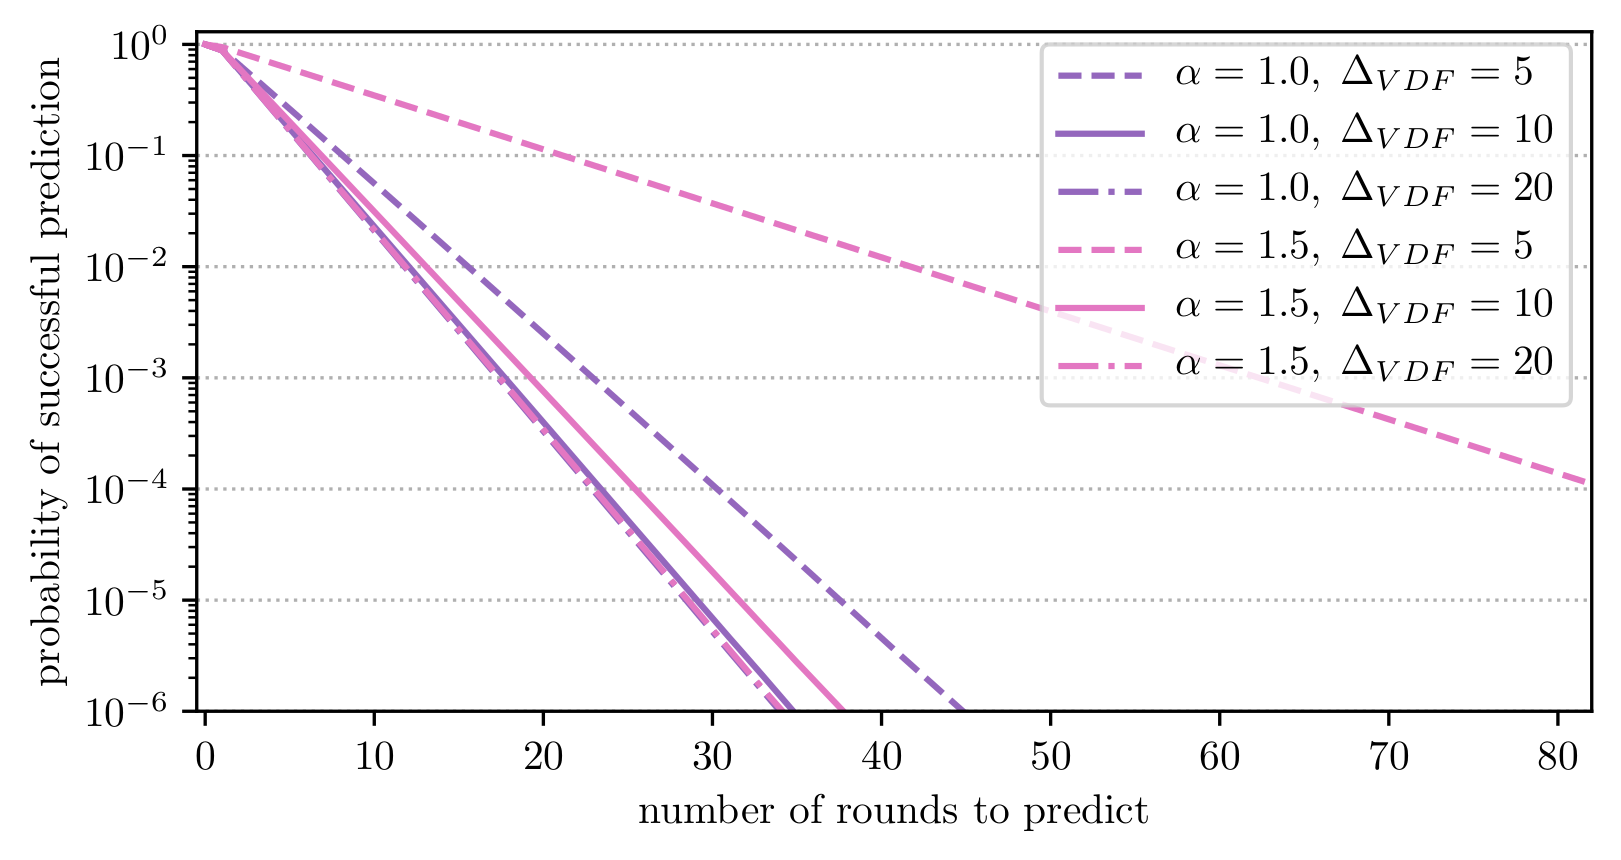

In [14]:
fig_unpredictability_random_draw(
    figname="pA-covert",
    parameters=[    
        (0.66, 1, 1,  5, "--", "C4"),
        (0.66, 1, 1, 10, "-",  "C4"),
        (0.66, 1, 1, 20, "-.", "C4"),        
        (0.66, 1.5, 1,  5, "--", "C6"),
        (0.66, 1.5, 1, 10, "-",  "C6"),
        (0.66, 1.5, 1, 20, "-.", "C6"),        
    ],    
    covert=True
)


## Relation between the parameters $ p_A $, $ \alpha $ and $ \Delta_{VDF} $ in the Covert Adversary Model

simulation completed after 52872.480097055435 seconds


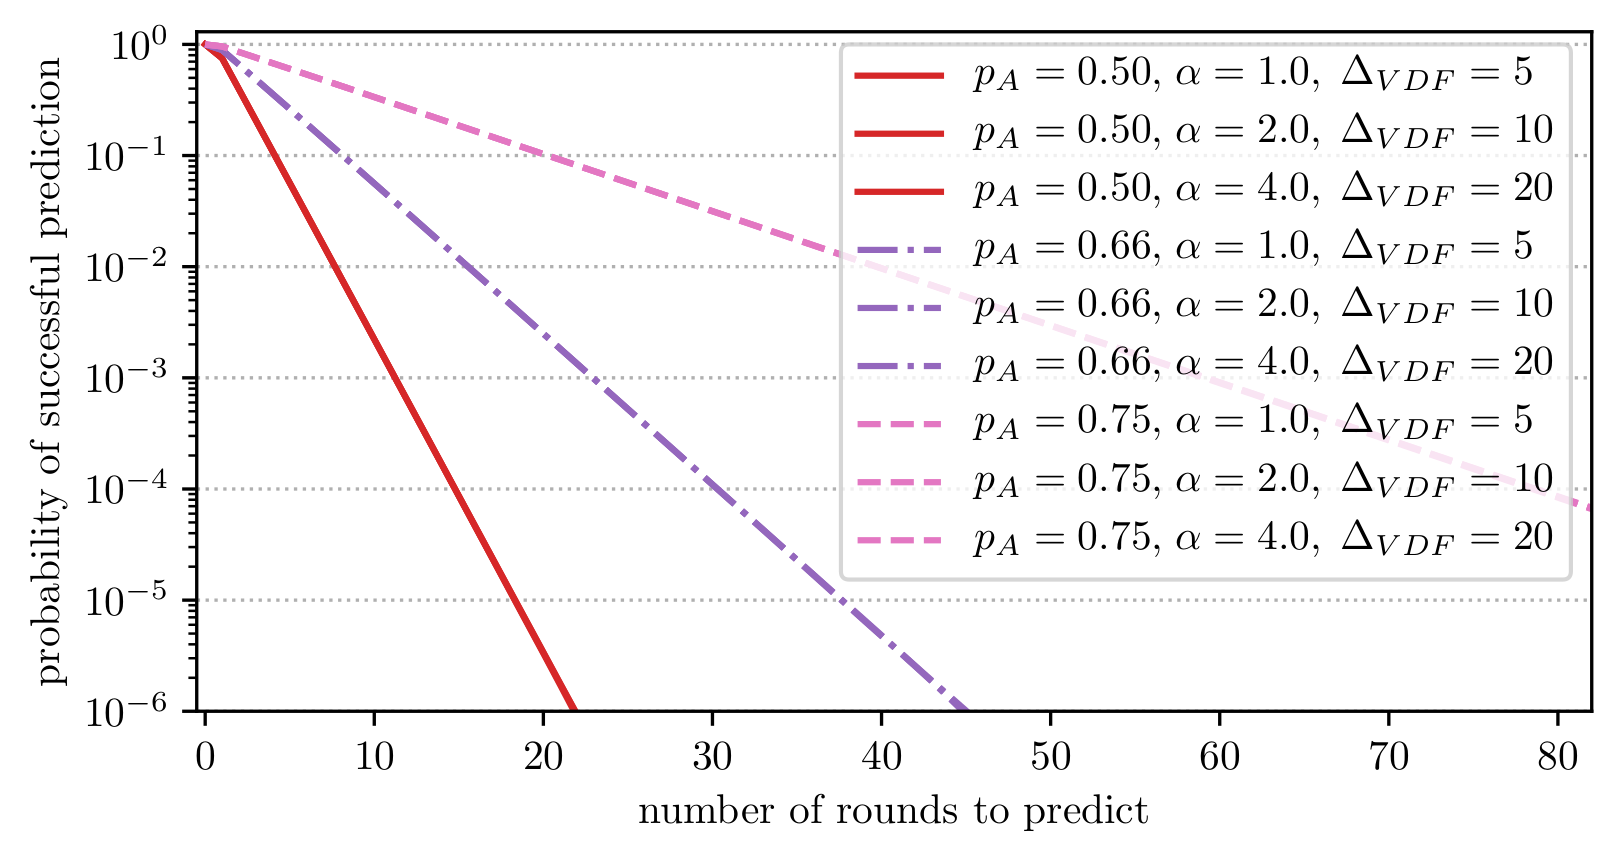

In [15]:
fig_unpredictability_random_draw(
    figname="relation-covert",
    parameters=[    
        (0.5, 1, 1,   5, "-", "C3"),
        (0.5, 2, 1,  10, "-", "C3"),
        (0.5, 4, 1,  20, "-", "C3"),        
        (0.66, 1, 1,   5, "-.", "C4"),
        (0.66, 2, 1,  10, "-.", "C4"),
        (0.66, 4, 1,  20, "-.", "C4"),
        (0.75, 1, 1,   5, "--", "C6"),
        (0.75, 2, 1,  10, "--", "C6"),
        (0.75, 4, 1,  20, "--", "C6"),        
    ],    
    covert=True
)


# Recovery from Asynchronous Network Conditions


In [16]:
# for the duration of the network outage (in units of Delta_{NET}), "value on x-axis"
# 10 is used for final figures, increase to speed up the simulation
STEPSIZE = 10

# number of simulations for each network outage duration
# 100000 is used for the final figures, decreased to speed up the simulation
# NUM_SIMS_PER_STEP = 100000
NUM_SIMS_PER_STEP = 100000

# number of rounds of normal operations between two network outages
# with 1000 rounds there is plenty of headroom for the protocol to stabilize
NUM_ROUNDS_BETWEEN_BREAKDOWNS = 1000


In [17]:
def simulate_network_breakdown(
    pA, alpha, delta_net, delta_vdf, delta_breakdown,
    num_rounds_pre_breakdown, 
    num_breakdowns
):   
    delta_vdf_h = delta_vdf
    delta_vdf_a = delta_vdf // alpha if delta_vdf % alpha == 0 else delta_vdf / alpha
    
    leaders = LeaderSequence(pA)
        
    # rH, rHs, rA... number of rounds completed by the (fastest) correct node and the adversary
    # tH, tHs, tA... current time for the (fastest) correct node and the adversary
    rH, rHs, rA = 0, 0, 0
    tH, tHs, tA = 0, 0, 0
        
    advantage = 0
    advantage_durations = [0]
    breakdown_durations = []
    
    t_frame_start = 0
    
    tH_next  = 0           if leaders[0] == H else delta_vdf_h
    tHs_next = delta_net   if leaders[0] == H else delta_vdf_h
    tA_next  = delta_vdf_a if leaders[0] == H else 0

    breakdown_start_round = num_rounds_pre_breakdown
    breakdown_end = None
    breakdown_round_delta = 0
    
    while len(breakdown_durations) < num_breakdowns:        
        if breakdown_end is None and rH == breakdown_start_round:
            breakdown_end = tH + delta_breakdown
            breakdown_round_delta = rA - rH            
            
        elif breakdown_end and tH >= breakdown_end and rA - rH <= breakdown_round_delta:
            breakdown_durations.append(tH - breakdown_end)
            breakdown_start_round = rH + num_rounds_pre_breakdown
            breakdown_end = None
        
        # adversary makes a step, and advantage increases by 1
        if tA_next <= tH_next: 
            rA += 1
            t_next = tA_next
            tA = tA_next
            if leaders[rA] == H:
                tA_next += delta_vdf_a
            new_advantage = advantage + 1
                            
        # fastest honest node makes a step
        else:
            rH += 1
            # reset adversary if overtaken by correct node
            if rH > rA:                
                tA_next = tH_next              
            
            t_next = tH_next
            tH = tH_next
            if leaders[rH] == H:
                if breakdown_end and tH < breakdown_end:
                    tH_next += delta_vdf_h
                    tHs_next += delta_vdf_h
                else:
                    tH_next = tHs_next
                    tHs_next += delta_net
            else:
                tH_next += delta_vdf_h
                tHs_next += delta_vdf_h
            
            new_advantage = advantage - 1
            
        if advantage != new_advantage:
            if t_frame_start < t_next:
                while len(advantage_durations) <= advantage:
                    advantage_durations.append(0)
                advantage_durations[advantage] += t_next - t_frame_start
            advantage = new_advantage   
            t_frame_start = t_next
                       
    return advantage_durations, breakdown_durations


In [18]:
def fig_network_breakdown(parameters, figsize=(6, 3), figname=None):
    tstart = time.time()
    fig, ax = plt.subplots(figsize=figsize)
    xs = list(range(1, 1000 + 1, STEPSIZE))
        
    for pA, alpha, delta_net, delta_vdf, style, color in parameters:
        ys_mean = []
        ys_bottom = []
        ys_top = []
        for d in xs:
            advantages, breakdown_durations = simulate_network_breakdown(
                pA=pA, alpha=alpha, delta_net=delta_net, delta_vdf=delta_vdf, 
                delta_breakdown=d,
                num_rounds_pre_breakdown=NUM_ROUNDS_BETWEEN_BREAKDOWNS, 
                num_breakdowns=NUM_SIMS_PER_STEP,
            )
            mean = np.mean(breakdown_durations)
            std = np.std(breakdown_durations)
            ys_mean.append(mean)
            ys_bottom.append(max(mean - std, 0))
            ys_top.append(mean + std)
            
        if figname == "network-outage-A":
            label= f"\\makebox[16mm]  [l]{{ $ p_A = {pA:.2f} $ }} "
        elif figname == "network-outage-B":
            label = f"\\makebox[14.5mm][l]{{ $ \\alpha = {float(alpha)}  $ }} "
        else:
            label=(
                f"\\makebox[16mm]  [l]{{ $ p_A     = {pA:.2f}      , $ }} "
                f"\\makebox[14.5mm][l]{{ $ \\alpha = {float(alpha)}  $ }} "
            )
        
        ax.plot(xs, ys_mean, style, color=color, label=label)
        ax.fill_between(xs, ys_bottom, ys_top, color=color, alpha=0.2)
        
    tend = time.time()
    print(f"simulation completed after {tend - tstart} seconds")
    
    # plot axis labels and title
    ax.set(
        xlabel='duration of network outage (in units of $ \Delta_{NET} $)', 
        ylabel='expected recovery time (in units of $ \Delta_{NET} $)',
    )
    ax.grid(axis="y", linestyle=":")

    plt.ylim(-50, 2200)
    plt.legend(loc="upper left")
        
    if figname and SAVE_FIGURES_AS_PDFS:
        plt.savefig(
            f"../paper/figures/sim-{figname}-{STEPSIZE}-{NUM_SIMS_PER_STEP}.pdf", 
            bbox_inches="tight"
        )
    plt.show()   


## Expected Recovery Times for different values of $ p_A $ ($ \Delta_{VDF} = 10 $, $ \alpha=1.0 $)

simulation completed after 43913.49691653252 seconds


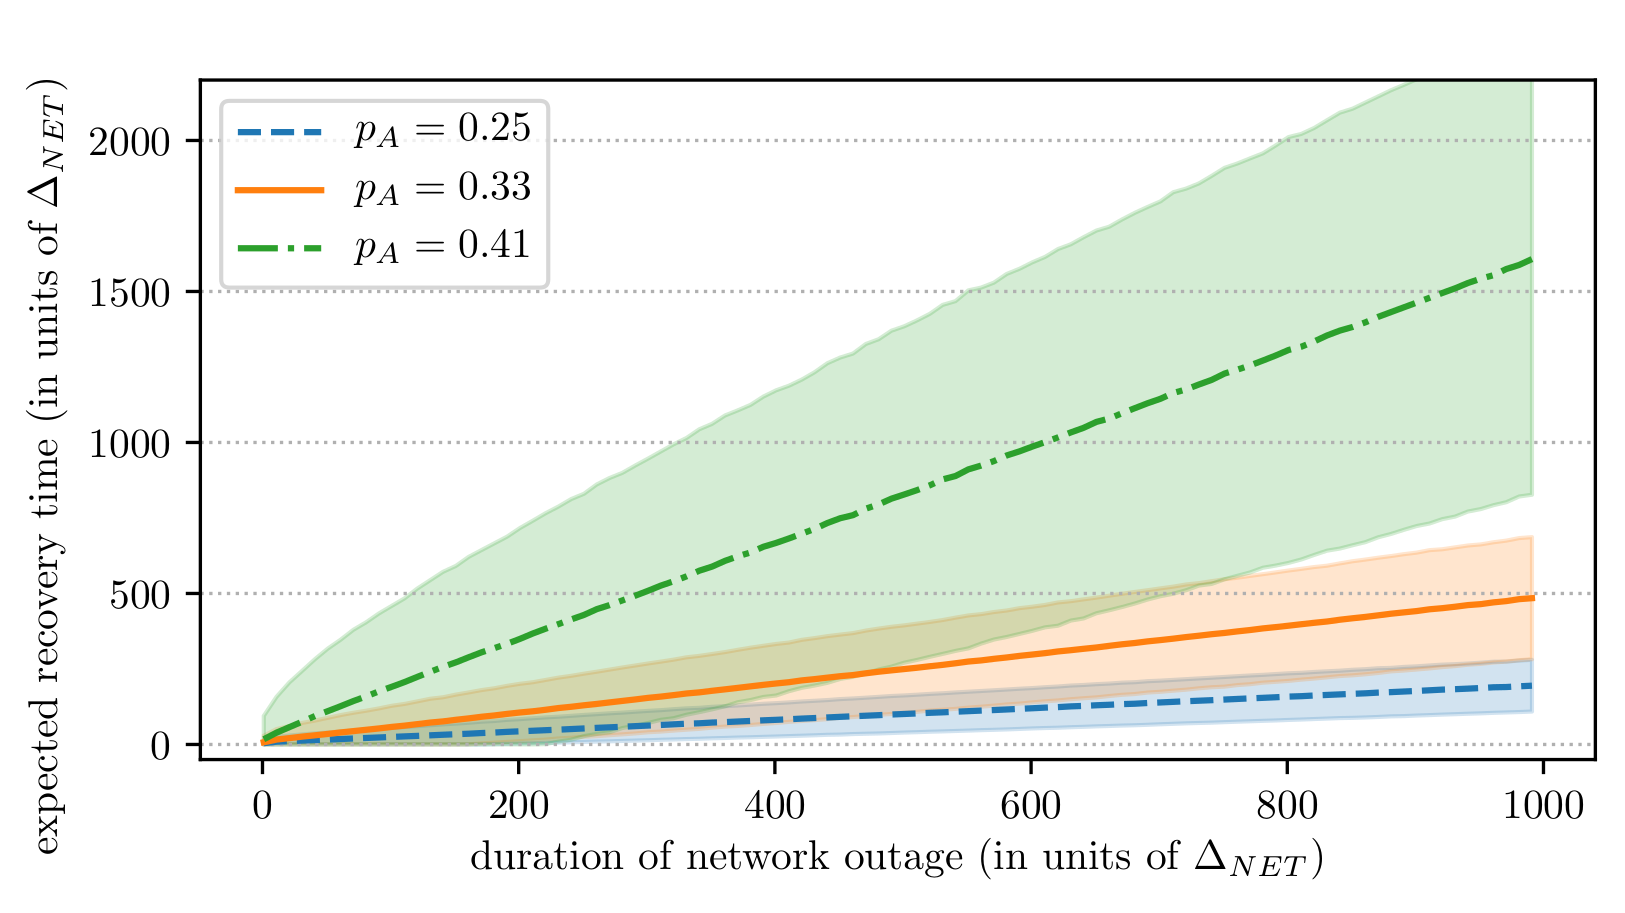

In [19]:
fig_network_breakdown(    
    parameters=[    
        (0.25, 1.00, 1, 10, "--", "C0"),
        (0.33, 1.00, 1, 10, "-",  "C1"),
        (0.41, 1.00, 1, 10, "-.", "C2"),        
    ],
    figname="network-outage-A"
 )


## Expected Recovery Times for different values of $ \alpha $ ($ \Delta_{VDF} = 10 $, $ p_A = 0.33 $)

simulation completed after 51500.852231264114 seconds


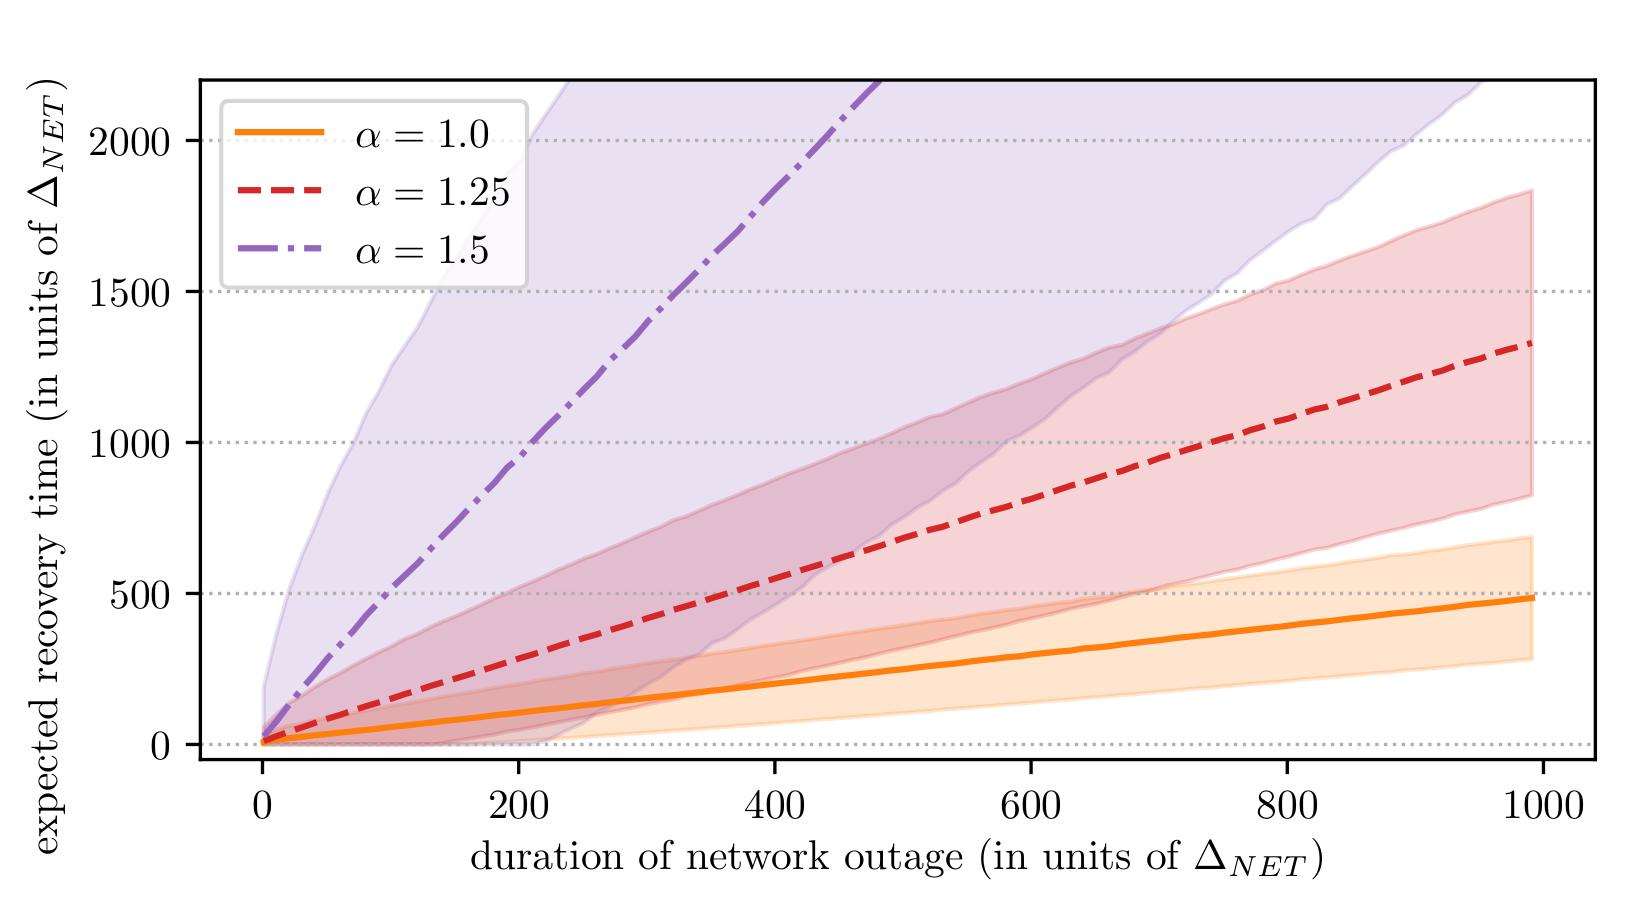

In [20]:
fig_network_breakdown(    
    parameters=[    
        (0.33, 1.00, 1, 10, "-",  "C1"),
        (0.33, 1.25, 1, 10, "--", "C3"),
        (0.33, 1.50, 1, 10, "-.", "C4"),  
    ],    
    figname="network-outage-B"
 )


# Comparision of RR and RS variants ($ \alpha = 1 $)

In [21]:
# configures the number of simulations to be run for each RandRunner-RR configuration
# 100000 is used for the final figures, 100-1000 is good for explorative testing
NUM_SIMULATIONS_RR = 100000

# the number of rounds for the RandRunner-RS simulations is controlled by the DEFAULT_NUM_ROUNDS 
# parameter as before

In [22]:
def simulate_round_robin_advantages_wrapper(params):
    return simulate_round_robin_advantages(*params)

def simulate_round_robin_advantages(n, f, alpha, delta_net, delta_vdf, iterations=100):
    advantages_dist_sum = [0.0]
    
    for iteration in range(iterations):
        seq = random_round_robin_sequence(n, f)
        TH, THs, TA, _, advantages = simulate(
            alpha=alpha, delta_net=delta_net, delta_vdf=delta_vdf, num_rounds=2*n, round_robin_sequence=seq
        )
        # remove the first period of n rounds, afterwards the advantage sequence repeats
        t_end_of_first_period = TH[n]
        advantages = [(t1, t2, a) for t1, t2, a in advantages if t1 >= t_end_of_first_period]
        dist = advantage_distribution(advantages)
        
        while len(dist) > len(advantages_dist_sum):
            advantages_dist_sum.append(0.0)
        
        for i, d in enumerate(dist):
            advantages_dist_sum[i] += d

    for i in range(len(advantages_dist_sum) - 1, 0, -1):
        advantages_dist_sum[i - 1] += advantages_dist_sum[i]   
        
    for i, d in enumerate(advantages_dist_sum):
        advantages_dist_sum[i] = d / iterations        
    
    return advantages_dist_sum

def simulate_round_robin_max_advantages(n, f, alpha, delta_net, delta_vdf, iterations=100):
    max_advantage_ctrs = [0]
    
    for iteration in range(iterations):
        seq = random_round_robin_sequence(n, f)
        TH, THs, TA, _, advantages = simulate(
            alpha=alpha, delta_net=delta_net, delta_vdf=delta_vdf, num_rounds=2*n, round_robin_sequence=seq
        )
        # remove the first period of n rounds, afterwards the advantage sequence repeats
        a_max = max(a for t1, t2, a in advantages)
        
        while len(max_advantage_ctrs) <= a_max:
            max_advantage_ctrs.append(0)
            
        max_advantage_ctrs[a_max] += 1

    for i in range(0, len(max_advantage_ctrs) - 1):
        max_advantage_ctrs[i + 1] += max_advantage_ctrs[i]
        
    return [c / iterations for i, c in enumerate(max_advantage_ctrs)]


In [23]:
def fig_unpredictability_random_draw_rr_vs_rs(
    rr_parameters,
    rs_parameters, 
    covert, 
    figname="undefined",
    num_rounds=DEFAULT_NUM_ROUNDS, 
    figsize=(6, 3), 
    ylim=1e-6,    
    loc='upper right',
    bbox_to_anchor=(1.0, 1.012),
    rr_iterations=1000,
):   
    tstart = time.time()
    with multiprocessing.Pool(len(rs_parameters)) as p:
        advantage_distributions = p.map(
            unpredictability_simulation_get_distribution, 
            [(covert, num_rounds, *p) for p in rs_parameters]
        )    
    tend = time.time()
    print(f"RS simulation completed after {tend - tstart} seconds")
    
    def all_equal(i):
        v = rs_parameters[0][i]
        for w in rs_parameters[1:]:
            if w[i] != v:
                return False
        return True
    
    add_pA_label        = not all_equal(0)
    add_alpha_label     = not all_equal(1)
    add_delta_net_label = not all_equal(2)
    add_delta_vdf_label = not all_equal(3)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    tstart = time.time()
    with multiprocessing.Pool(len(rr_parameters)) as p2:
        rr_advantage_distributions = p2.map(
            simulate_round_robin_advantages_wrapper, 
            [
                (n, f, alpha, delta_net, delta_vdf, rr_iterations) 
                for n, f, alpha, delta_net, delta_vdf, _, _ in rr_parameters
            ]
        ) 
    tend = time.time()
    print(f"RR simulation completed after {tend - tstart} seconds")    
    
    for dist, (n, f, alpha, delta_net, delta_vdf, style, color) in zip(
        rr_advantage_distributions, rr_parameters
    ):
        dist.append(0.0)
        ax.plot(
            range(len(dist)), dist, style, color=color, 
            label=f"\\makebox[26.5mm][l]{{ RandRunner-RR }} ($ n = {n}, f = {f} $)"
        )
    
    for dist, (pA, alpha, delta_net, delta_vdf, style, color) in zip(advantage_distributions, rs_parameters):
        ax.plot(
            range(len(dist)), dist, style, color=color, 
            label=f"\\makebox[26.5mm][l]{{ RandRunner-RS }} ($ p_A = {pA:.2f} $) "
        )

    # plot axis labels and title
    ax.set(
        xlabel='number of rounds to predict', 
        ylabel='probability of successful prediction',
    )
    ax.grid(axis="y", linestyle=":")
    plt.xlim(-0.5, 82)
    plt.ylim(ylim, 1.3)
    plt.yscale("log")
    plt.legend(loc=loc, bbox_to_anchor=bbox_to_anchor)
    if SAVE_FIGURES_AS_PDFS:
        plt.savefig(
            f"../paper/figures/sim-{figname}-{num_rounds}.pdf", 
            bbox_inches="tight"
        )
    plt.show() 
    

RS simulation completed after 1223.0693159103394 seconds
RR simulation completed after 2205.727038383484 seconds


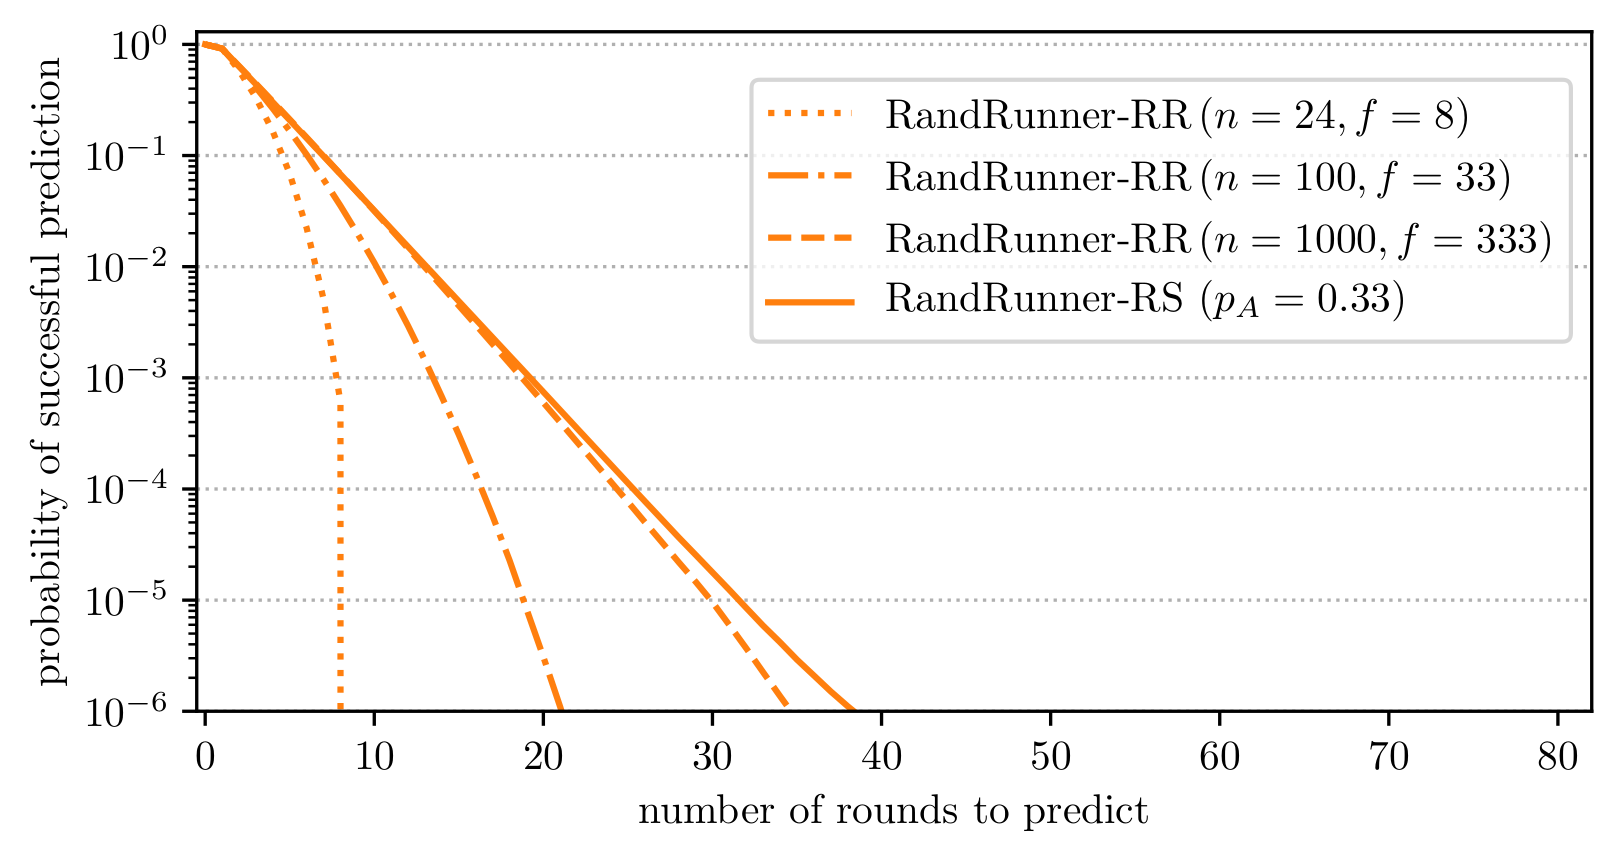

In [24]:
fig_unpredictability_random_draw_rr_vs_rs(
    figname="rr-vs-rs",
    rr_parameters=[
        (  24,   8, 1.00, 1, 10, ":",   "C1"),
        ( 100,  33, 1.00, 1, 10, "-.",  "C1"),
        (1000, 333, 1.00, 1, 10, "--",  "C1"),
    ],
    rs_parameters=[    
        (0.33, 1.00, 1, 10, "-",  "C1"),
    ],
    covert=False,
    loc='upper right',
    bbox_to_anchor=(1.0, 0.96),
    rr_iterations=10**3,  # no need to increase this as the RR variant is periodic
)


# Additional Simulations considering an Instantaneous Adaptive Adversary


In [25]:
# configures the number of simulations to be run for each configuration
# 10000 gives very clean figures, 100 is good for explorative testing
NUM_SIMULATIONS_ADAPTIVE = 100


In [26]:
def simulate_adaptive(
    pA, alpha, delta_net, delta_vdf, 
    k, # number of instanenously corrupted leaders
  ):   
    delta_vdf_h = delta_vdf
    delta_vdf_a = delta_vdf // alpha if delta_vdf % alpha == 0 else delta_vdf / alpha
    
    leaders = LeaderSequence(pA)
        
    # rH, rHs, rA... number of rounds completed by the (fastest) correct node and the adversary
    # tH, tHs, tA... current time for the (fastest) correct node and the adversary
    rH, rHs, rA = 0, 0, k
    tH, tHs, tA = 0, 0, 0
        
    advantage = k
    max_advantage = advantage
        
    tH_next  = 0           if leaders[0] == H else delta_vdf_h
    tHs_next = delta_net   if leaders[0] == H else delta_vdf_h
    tA_next  = delta_vdf_a if leaders[0] == H else 0
    
    while advantage > 0:
       
        # adversary makes a step, and advantage increases by 1
        if tA_next <= tH_next: 
            rA += 1
            t_next = tA_next
            tA = tA_next
            if leaders[rA] == H:
                tA_next += delta_vdf_a
            new_advantage = advantage + 1
                            
        # fastest honest node makes a step
        else:
            rH += 1
            # reset adversary if overtaken by correct node
            if rH > rA:                
                tA_next = tH_next              
            
            t_next = tH_next
            tH = tH_next
            if leaders[rH] == H:
                tH_next = tHs_next
                tHs_next += delta_net
            else:
                tH_next += delta_vdf_h
                tHs_next += delta_vdf_h
            
            new_advantage = advantage - 1
            
        advantage = new_advantage   
        if advantage > max_advantage:
            max_advantage = advantage
                       
    return max_advantage


In [27]:
def fig_adaptive(n, f_max, alpha, figsize=(6, 3), figname="adaptive-corruptions"):
    tstart = time.time()
    fig, ax = plt.subplots(figsize=figsize)
    
    STEP = 1
    
    xs = list(range(0, f_max + 1, STEP))
    delta_net = 1
    
    for delta_vdf, style, color in [(5, "--", "C0"), (10, "-", "C1"), (20, "-.", "C2")]:
            
        max_advantages = []
        avg_max_advantages = []       
        median_max_advantages = []
        min_max_advantages = []
        max_max_advantages = []
     
        
        for f in range(0, f_max + 1, STEP):
            pA = f / n
            A = [simulate_adaptive(pA, alpha, delta_net, delta_vdf, f) for _ in range(NUM_SIMULATIONS_ADAPTIVE)]
            max_advantages.append(A)
            avg_max_advantages.append(np.mean(A))
            median_max_advantages.append(np.median(A))
            min_max_advantages.append(np.quantile(A, 0.05))
            max_max_advantages.append(np.quantile(A, 0.95))
            
        ax.plot(
            xs, avg_max_advantages, 
            style, color=color, 
            label=f"\\makebox[16mm]  [l]{{ $ \\Delta_{{VDF}} = {delta_vdf} $ }} "
        )
            
        ax.fill_between(xs, min_max_advantages, max_max_advantages, color=color, alpha=0.2)
            
    tend = time.time()
    print(f"simulation completed after {tend - tstart} seconds")
    
    # plot axis labels and title
    ax.set(
        xlabel='number of instantaneous adaptive corruptions $ f $', 
        ylabel='number of predictable beacon outputs',
    )
    ax.grid(axis="y", linestyle=":")
    plt.ylim(-2, 75)
    plt.legend(loc="upper left")
    
    if figname and SAVE_FIGURES_AS_PDFS:
        plt.savefig(
            f"../paper/figures/sim-{figname}-n{n}-{NUM_SIMULATIONS_ADAPTIVE}.pdf", 
            bbox_inches="tight"
        )
    plt.show()


simulation completed after 50.6375412940979 seconds


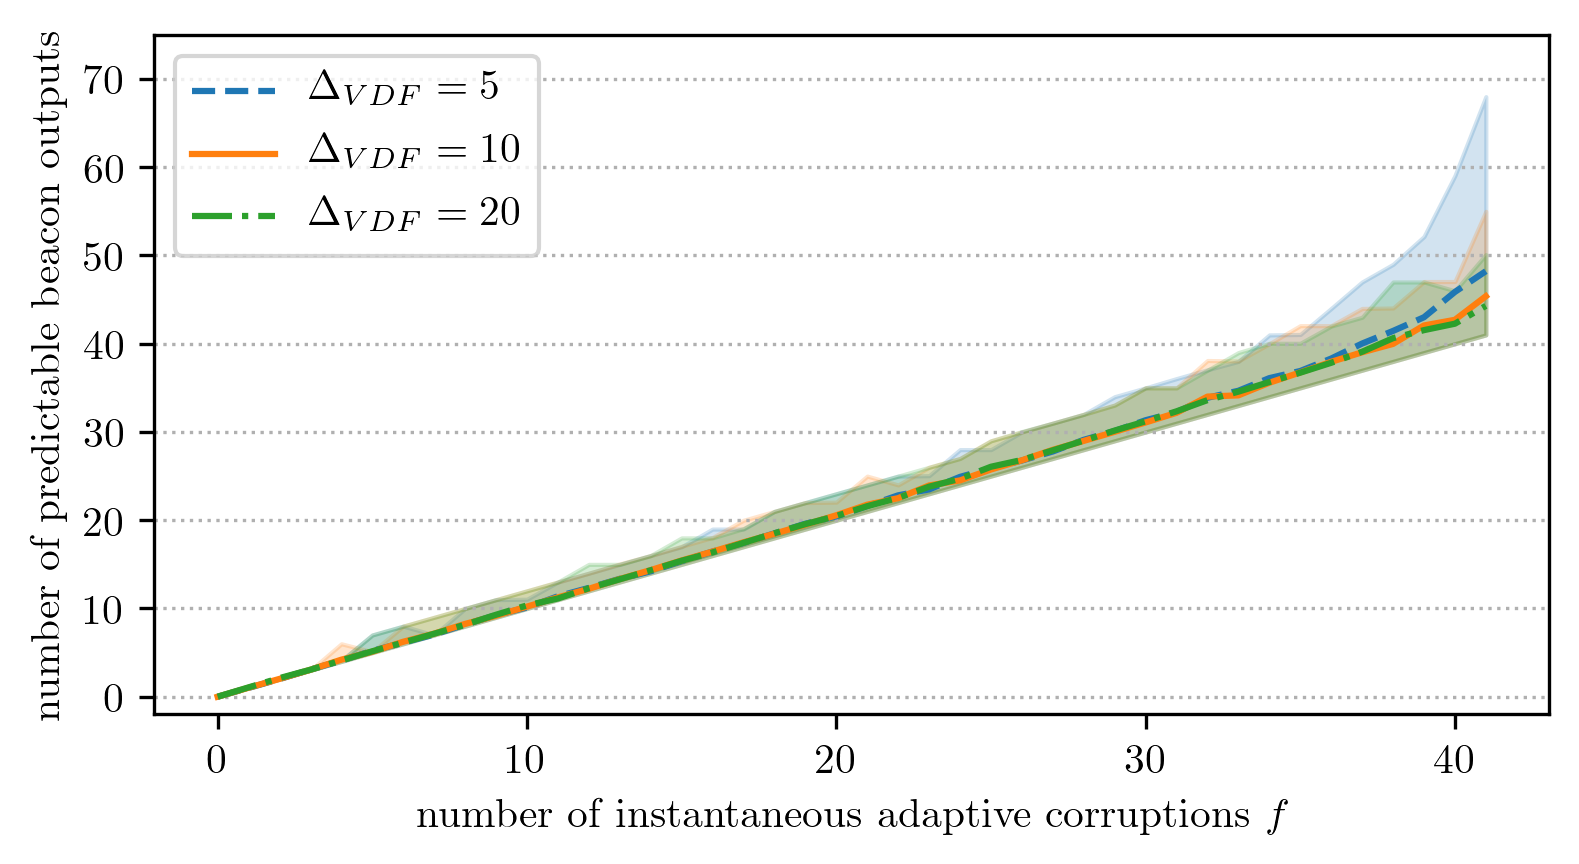

In [28]:
fig_adaptive(n=100, f_max=41, alpha=1.0)

Simulation of RandRunner-RS's unpredictability guarantees considering an adaptive adversary which may instantaneous corrupt $ f $ nodes ($ n = 100 $, $ \alpha = 1.0 $, $ \Delta_{NET} = 1 $): The simulation is repeated $ 10000 $ times for each datapoint. The lines report the observed average of the number of rounds the adversary can predict, whereas the values between the $ 5\% $ and $ 95\% $ quantile are indicated by the filled areas.

# Additional Illustrations

The figures show how the protocol progresses from the views of the adversary and correct nodes over time and rounds. The number of predictable rounds at each point in time are indicated by the orange bars.

In [29]:
def plot_simulation(
    alpha, delta_net, delta_vdf, num_rounds, pA=None, round_robin_sequence=None, covert=False
):
    delta_vdf_h = delta_vdf
    delta_vdf_a = delta_vdf // alpha if delta_vdf % alpha == 0 else Fraction(delta_vdf, alpha)
    
    sim_func = simulate_covert if covert else simulate
    TH, THs, TA, leaders, advantages = sim_func(
            alpha, delta_net, delta_vdf, num_rounds + 100, pA, round_robin_sequence
        )
    
    if leaders.round_robin:
        title = (f"Unpredictability Simulation for RandRunner-RR ($ "
                 f"n = {leaders.n}, "
                 f"f = {leaders.f}, "
                 f"\\alpha = {float(alpha)}, "
                 f"\\Delta_{{NET}} = {float(delta_net)}, "
                 f"\\Delta_{{VDF}} = {float(delta_vdf)} $)")                 
    else:
        title = ("Unpredictability Simulation for RandRunner-RS ($ "
                 f"f/n = {pA}, "
                 f"\\alpha = {alpha}, "
                 f"\\Delta_{{NET}} = {float(delta_net)}, "
                 f"\\Delta_{{VDF}} = {float(delta_vdf)} $)")          
    
    if covert:
        TH_lines = [[TH[0]]]
        RH_lines = [[0]]
        for r, (v1, v2) in enumerate(zip(TH, TH[1:])):
            if v2 - v1 == delta_net:
                RH_lines[-1].append(r + delta_net/delta_vdf * 2)
                TH_lines[-1].append(v2 + delta_net)
                RH_lines.append([r, r + 1])
                TH_lines.append([v2, v2])
            else:
                RH_lines[-1].append(r + 1)
                TH_lines[-1].append(v2)
        
    else:
        TH_lines = [[TH[0]]]
        RH_lines = [[0]]
        for r, (v1, v2) in enumerate(zip(TH, TH[1:])):
            if v2 - v1 == delta_net:
                RH_lines[-1].append(r + delta_net/delta_vdf * 2)
                TH_lines[-1].append(v2 + delta_net)
                RH_lines.append([r, r + 1])
                TH_lines.append([v2, v2])
            else:
                RH_lines[-1].append(r + 1)
                TH_lines[-1].append(v2)

    THs_lines = [THs[0]]
    RHs_lines = [0]
    for r, (v1, v2) in enumerate(zip(THs, THs[1:])):
        if v2 - v1 == delta_net:
            RHs_lines.append(r + delta_net / delta_vdf)
            THs_lines.append(v2)
        RHs_lines.append(r + 1)
        THs_lines.append(v2)

    TA_lines = [[TA[0]]]
    RA_lines = [[0]]
    for r, (v1, v2) in enumerate(zip(TA, TA[1:])):
        if v1 != v2 and v2 - v1 != delta_vdf_a:
            RA_lines[-1].append(float(r + (v2 - v1) / delta_vdf_a))
            TA_lines[-1].append(float(v2))
            RA_lines.append([])
            TA_lines.append([])        
        RA_lines[-1].append(r + 1)
        TA_lines[-1].append(float(v2))


    fig, ax = plt.subplots()
            
    MARKER_A = "P"
    MARKER_H = "s"
    MARKER_Hs = "o"
    COLOR_A = "C3"
    COLOR_H = "C0"
    
    advantages_x = []
    advantages_y = []
    for tstart, tend, value in advantages:
        advantages_x.append(float(tstart))
        advantages_x.append(float(tend))
        advantages_y.append(value)
        advantages_y.append(value)
        
    ax.fill_between(advantages_x, 0, advantages_y, color="C1", alpha=0.3)
    
    # plot lines
    for x, y in zip(TA_lines, RA_lines):
        ax.plot(x, y, "-", color=COLOR_A)       
    
    if not covert:
        for x, y in zip(TH_lines, RH_lines):
            ax.plot(x, y, "--", color=COLOR_H)
    ax.plot(THs_lines, RHs_lines, "-", color=COLOR_H)

    # plot legend
    ax.plot([], [], "-", marker=MARKER_A, color=COLOR_A, label="adversary")
    ax.plot([], [], "--", marker=MARKER_H, color=COLOR_H, label="fastest correct node")
    ax.plot([], [], "-", marker=MARKER_Hs, color=COLOR_H, label="slowest correct nodes")

    # plot markers
    ax.plot(TH[1:],  range(1, len(TH)), MARKER_H, color=COLOR_H)
    ax.plot(THs[1:], range(1, len(THs)), MARKER_Hs, color=COLOR_H)
    ax.plot(TA[1:],  range(1, len(TA)), MARKER_A, color=COLOR_A)

    ax.set(xlabel='time', ylabel='round numbers and leaders', title=title)
    plt.xlim(-0.5, (THs[-101] + THs[-100]) / 2)
    plt.ylim(-0.2, num_rounds + 0.5)
    ax.grid(axis="y", linestyle=":")
    ax.set_yticks(range(num_rounds + 1))
    ax.set_yticklabels("")  
    ax.set_yticks(np.arange(0.5, num_rounds, 1.0), minor=True)
    ax.set_yticklabels([f"{r} {l}" for r, l in zip(range(1, num_rounds + 1), leaders)], minor=True)
    ax.tick_params(which='minor', length=0)
    plt.legend()
    plt.show()


## Simple RandRunner-RR Execution (no Network Delay, $ \alpha = 1.0 $)

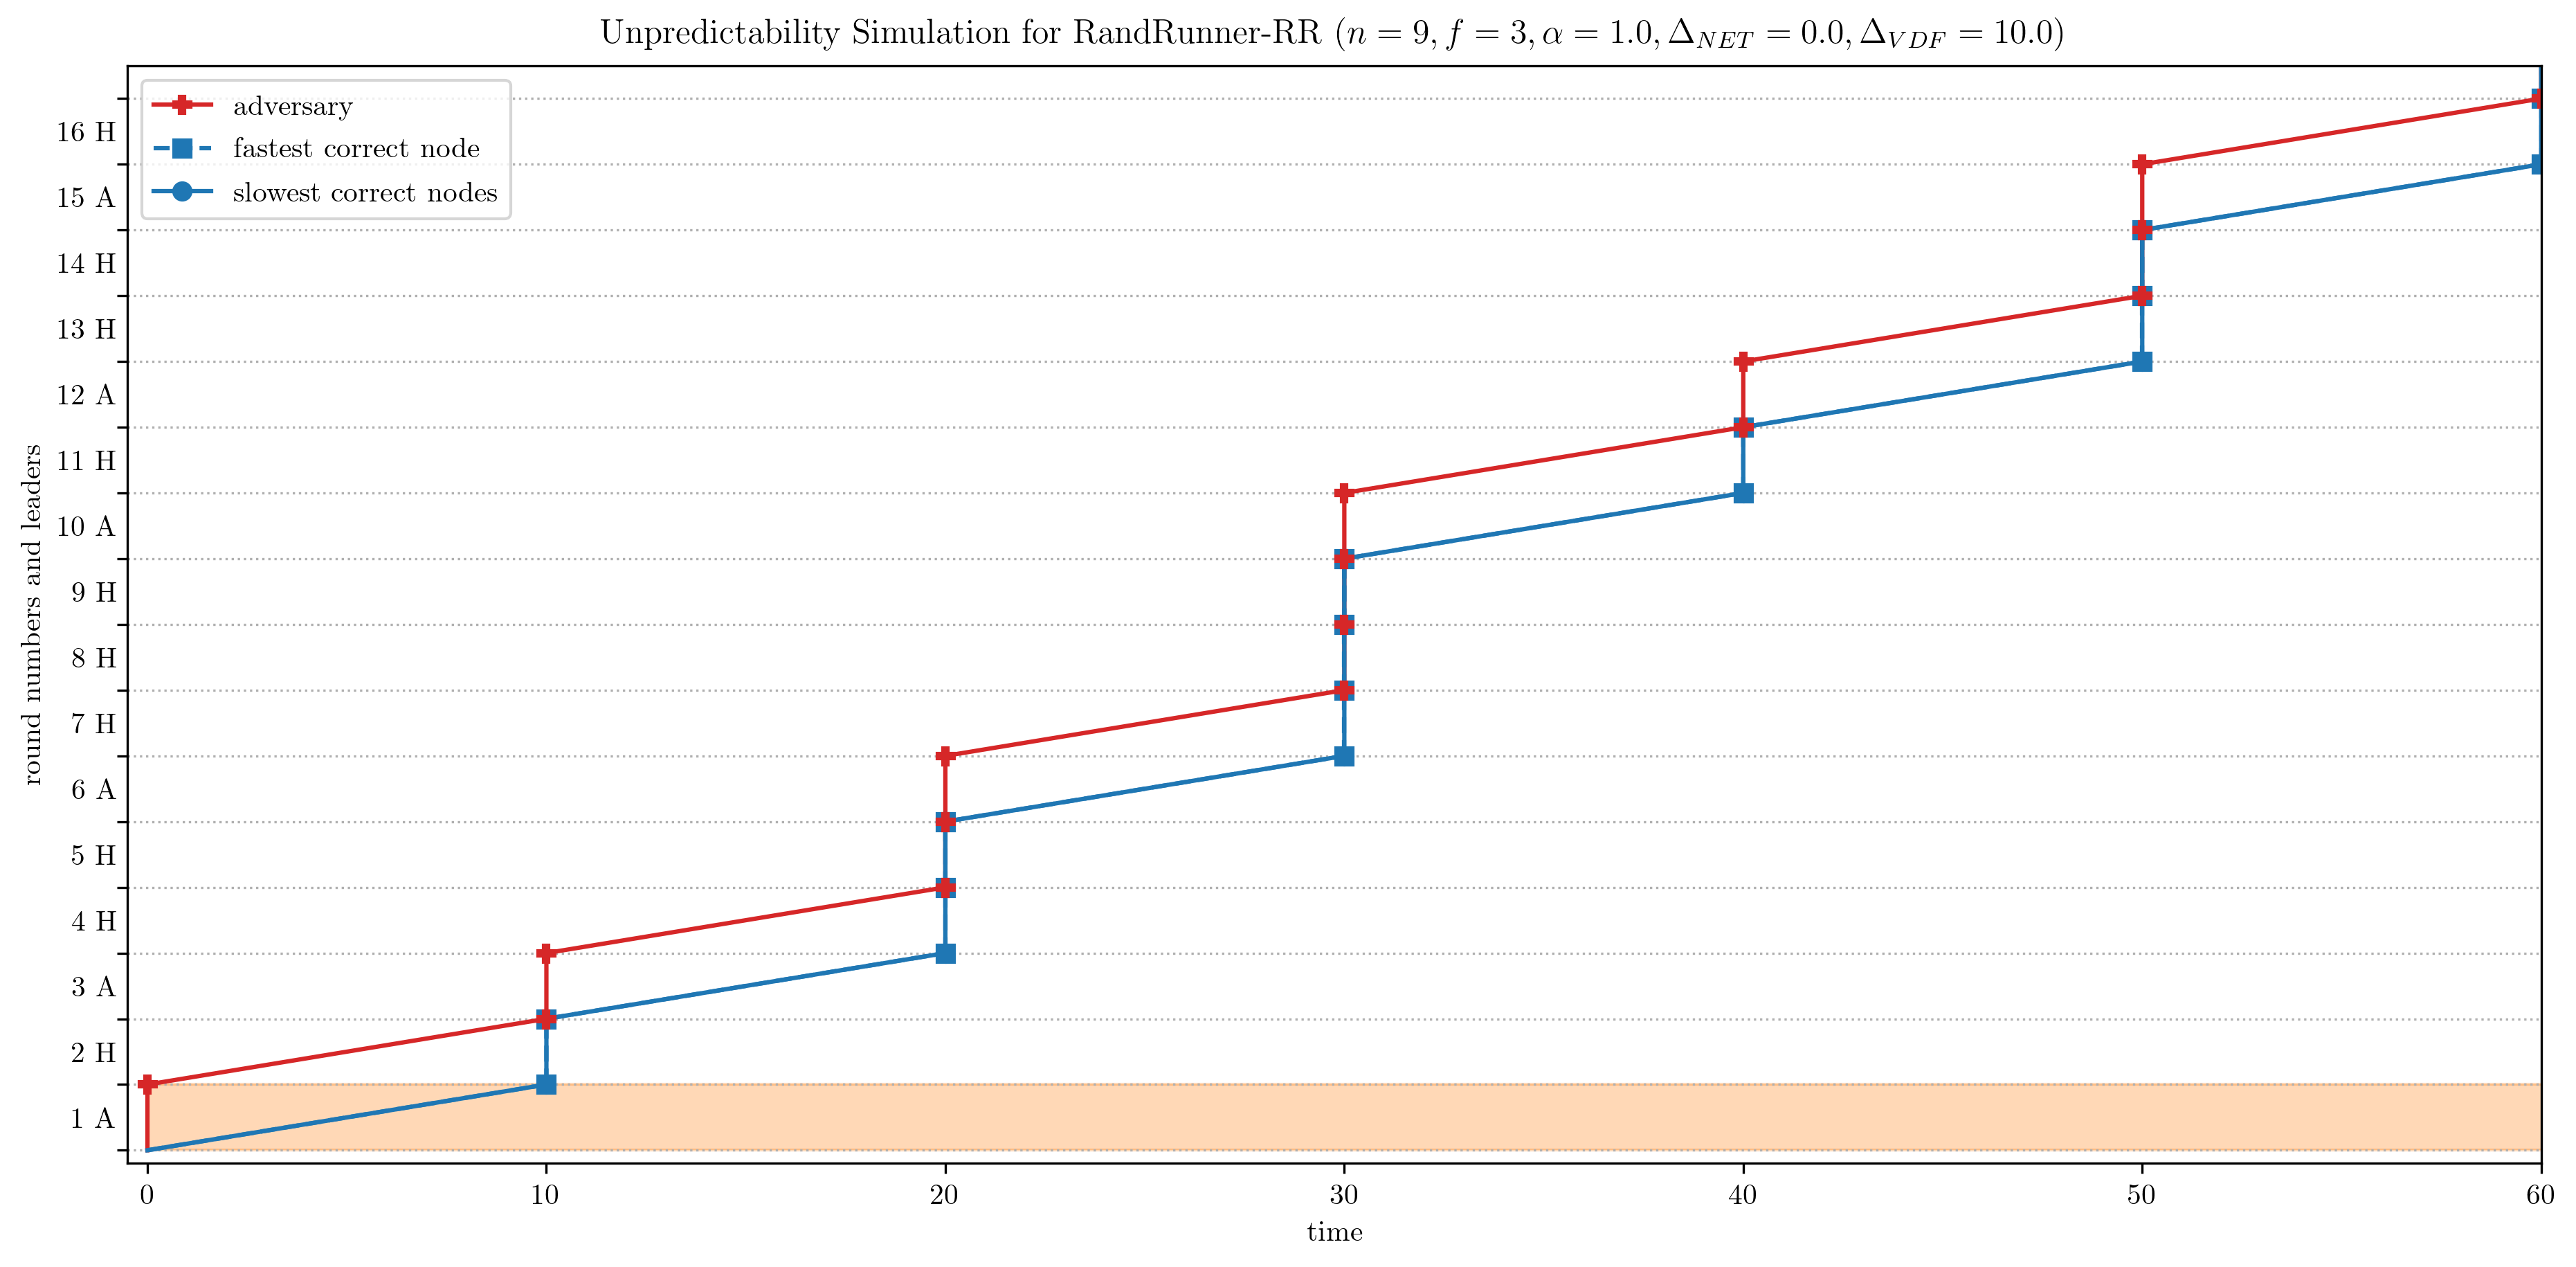

In [30]:
plot_simulation(
    alpha=1, delta_net=0, delta_vdf=10, num_rounds=16, 
    round_robin_sequence="A H A HH A HHH",
)

## Simple RandRunner-RR Execution (adding Network Delay for Correct Nodes, $ \alpha = 1.0 $)

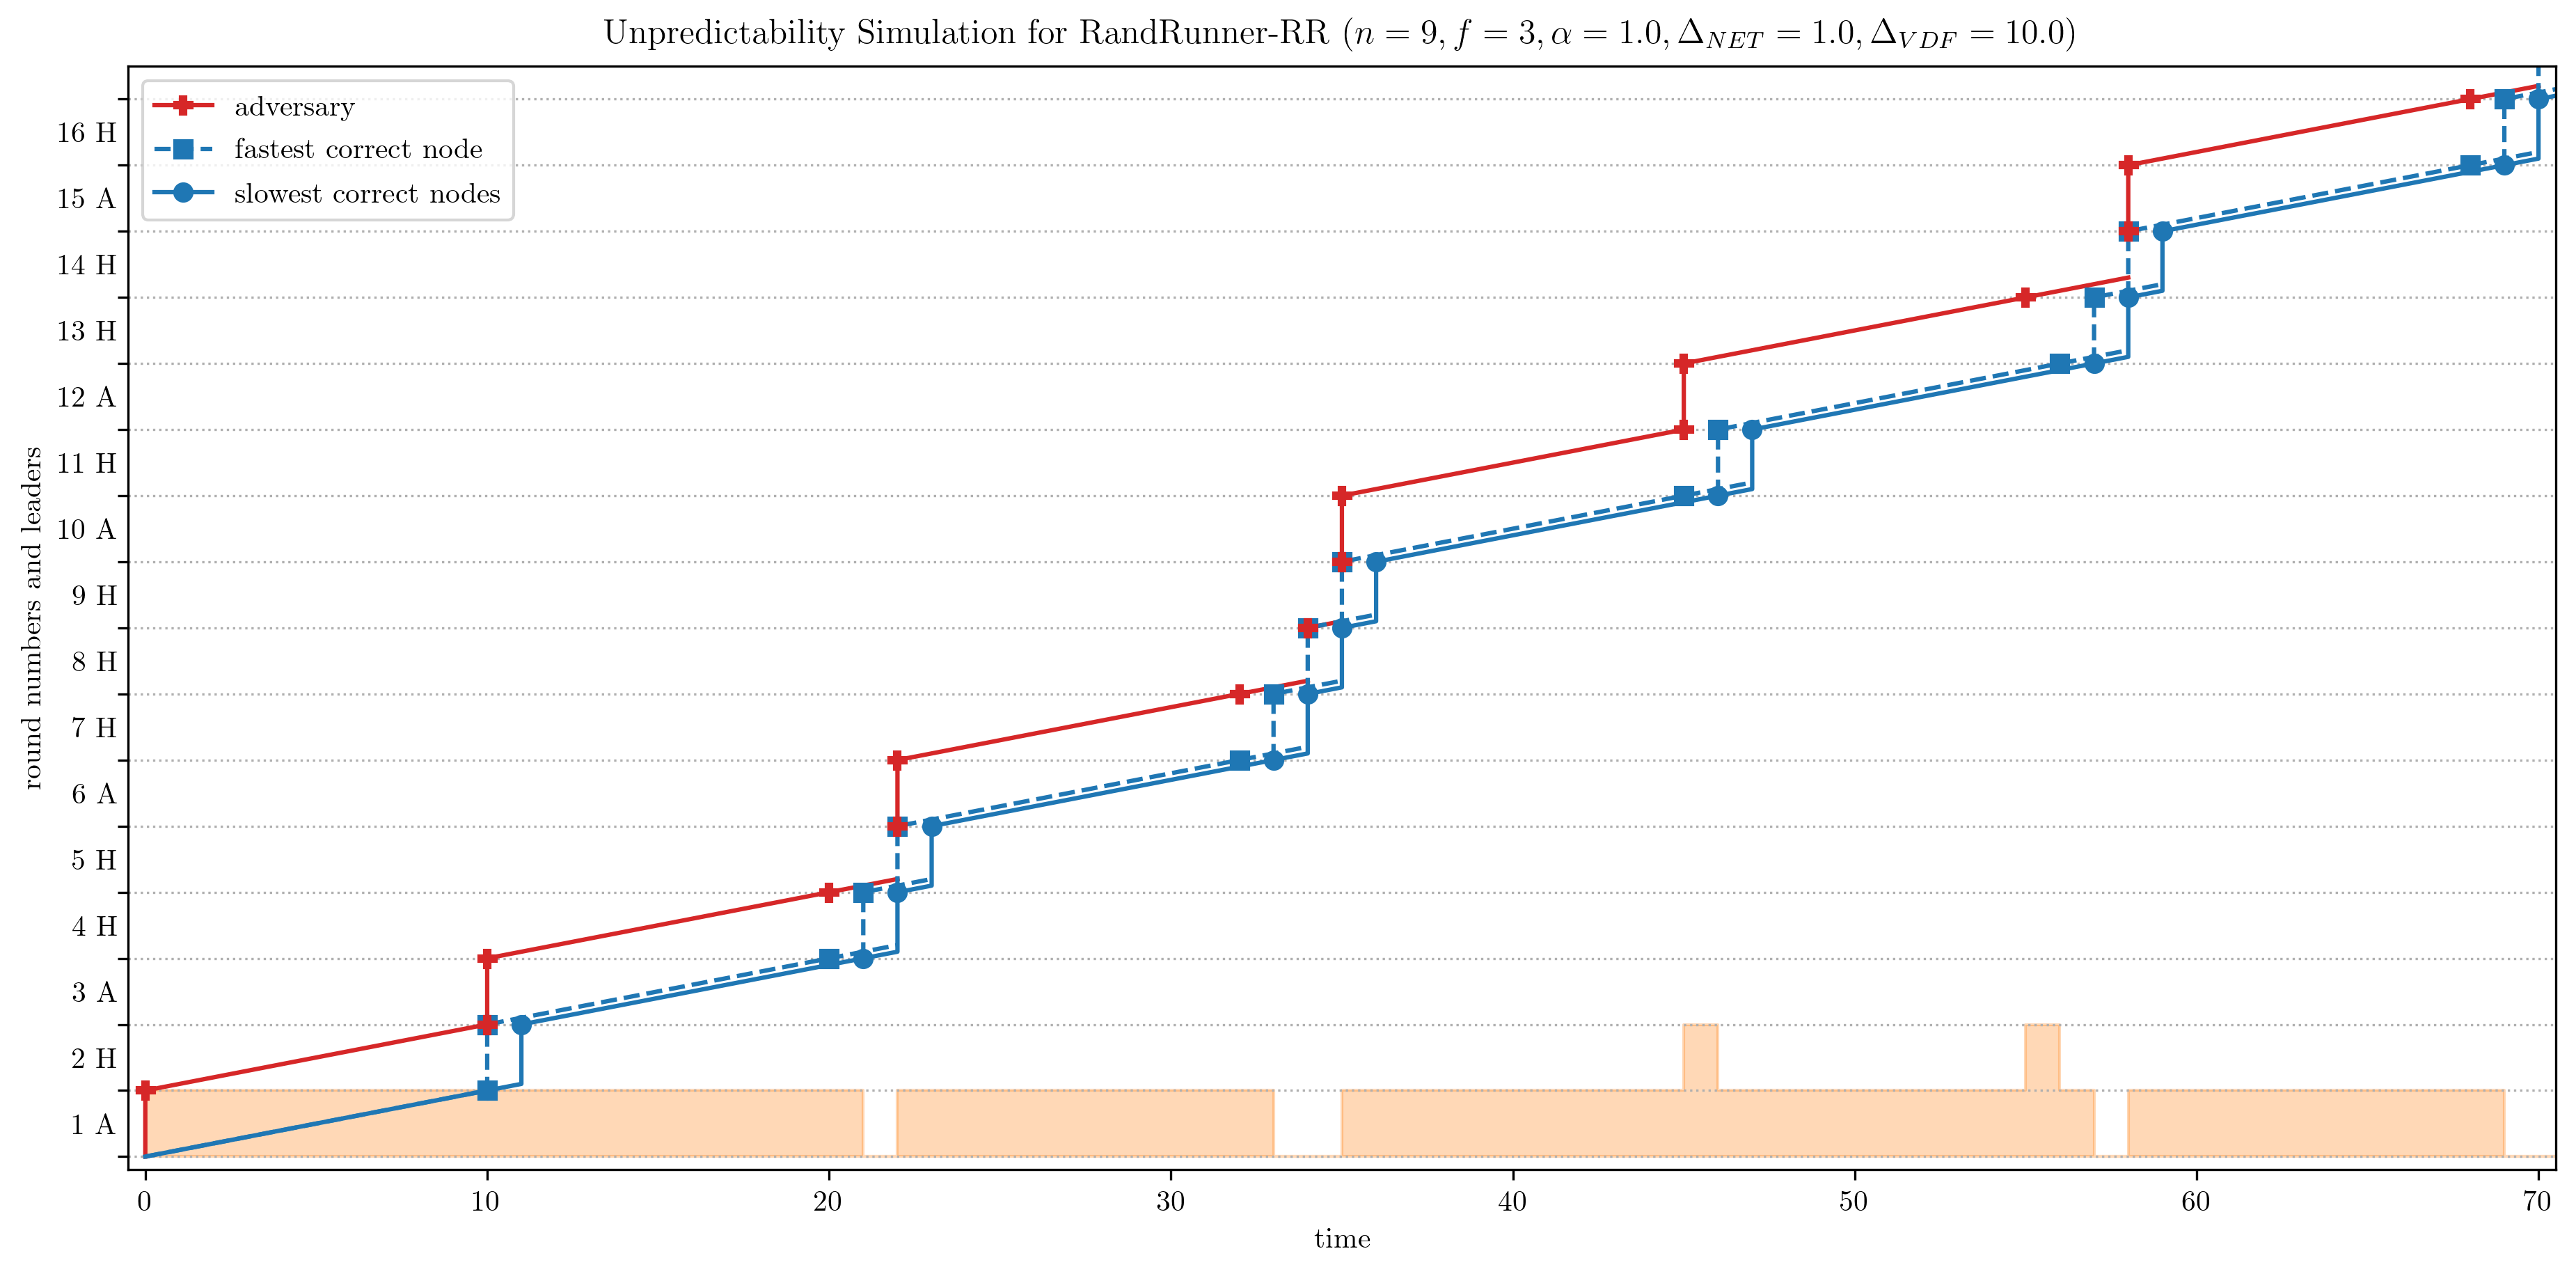

In [31]:
plot_simulation(
    alpha=1, delta_net=1, delta_vdf=10, num_rounds=16, 
    round_robin_sequence="A H A HH A HHH",
)

## Example RandRunner-RR (with Network Delay and Different Computational Speed)

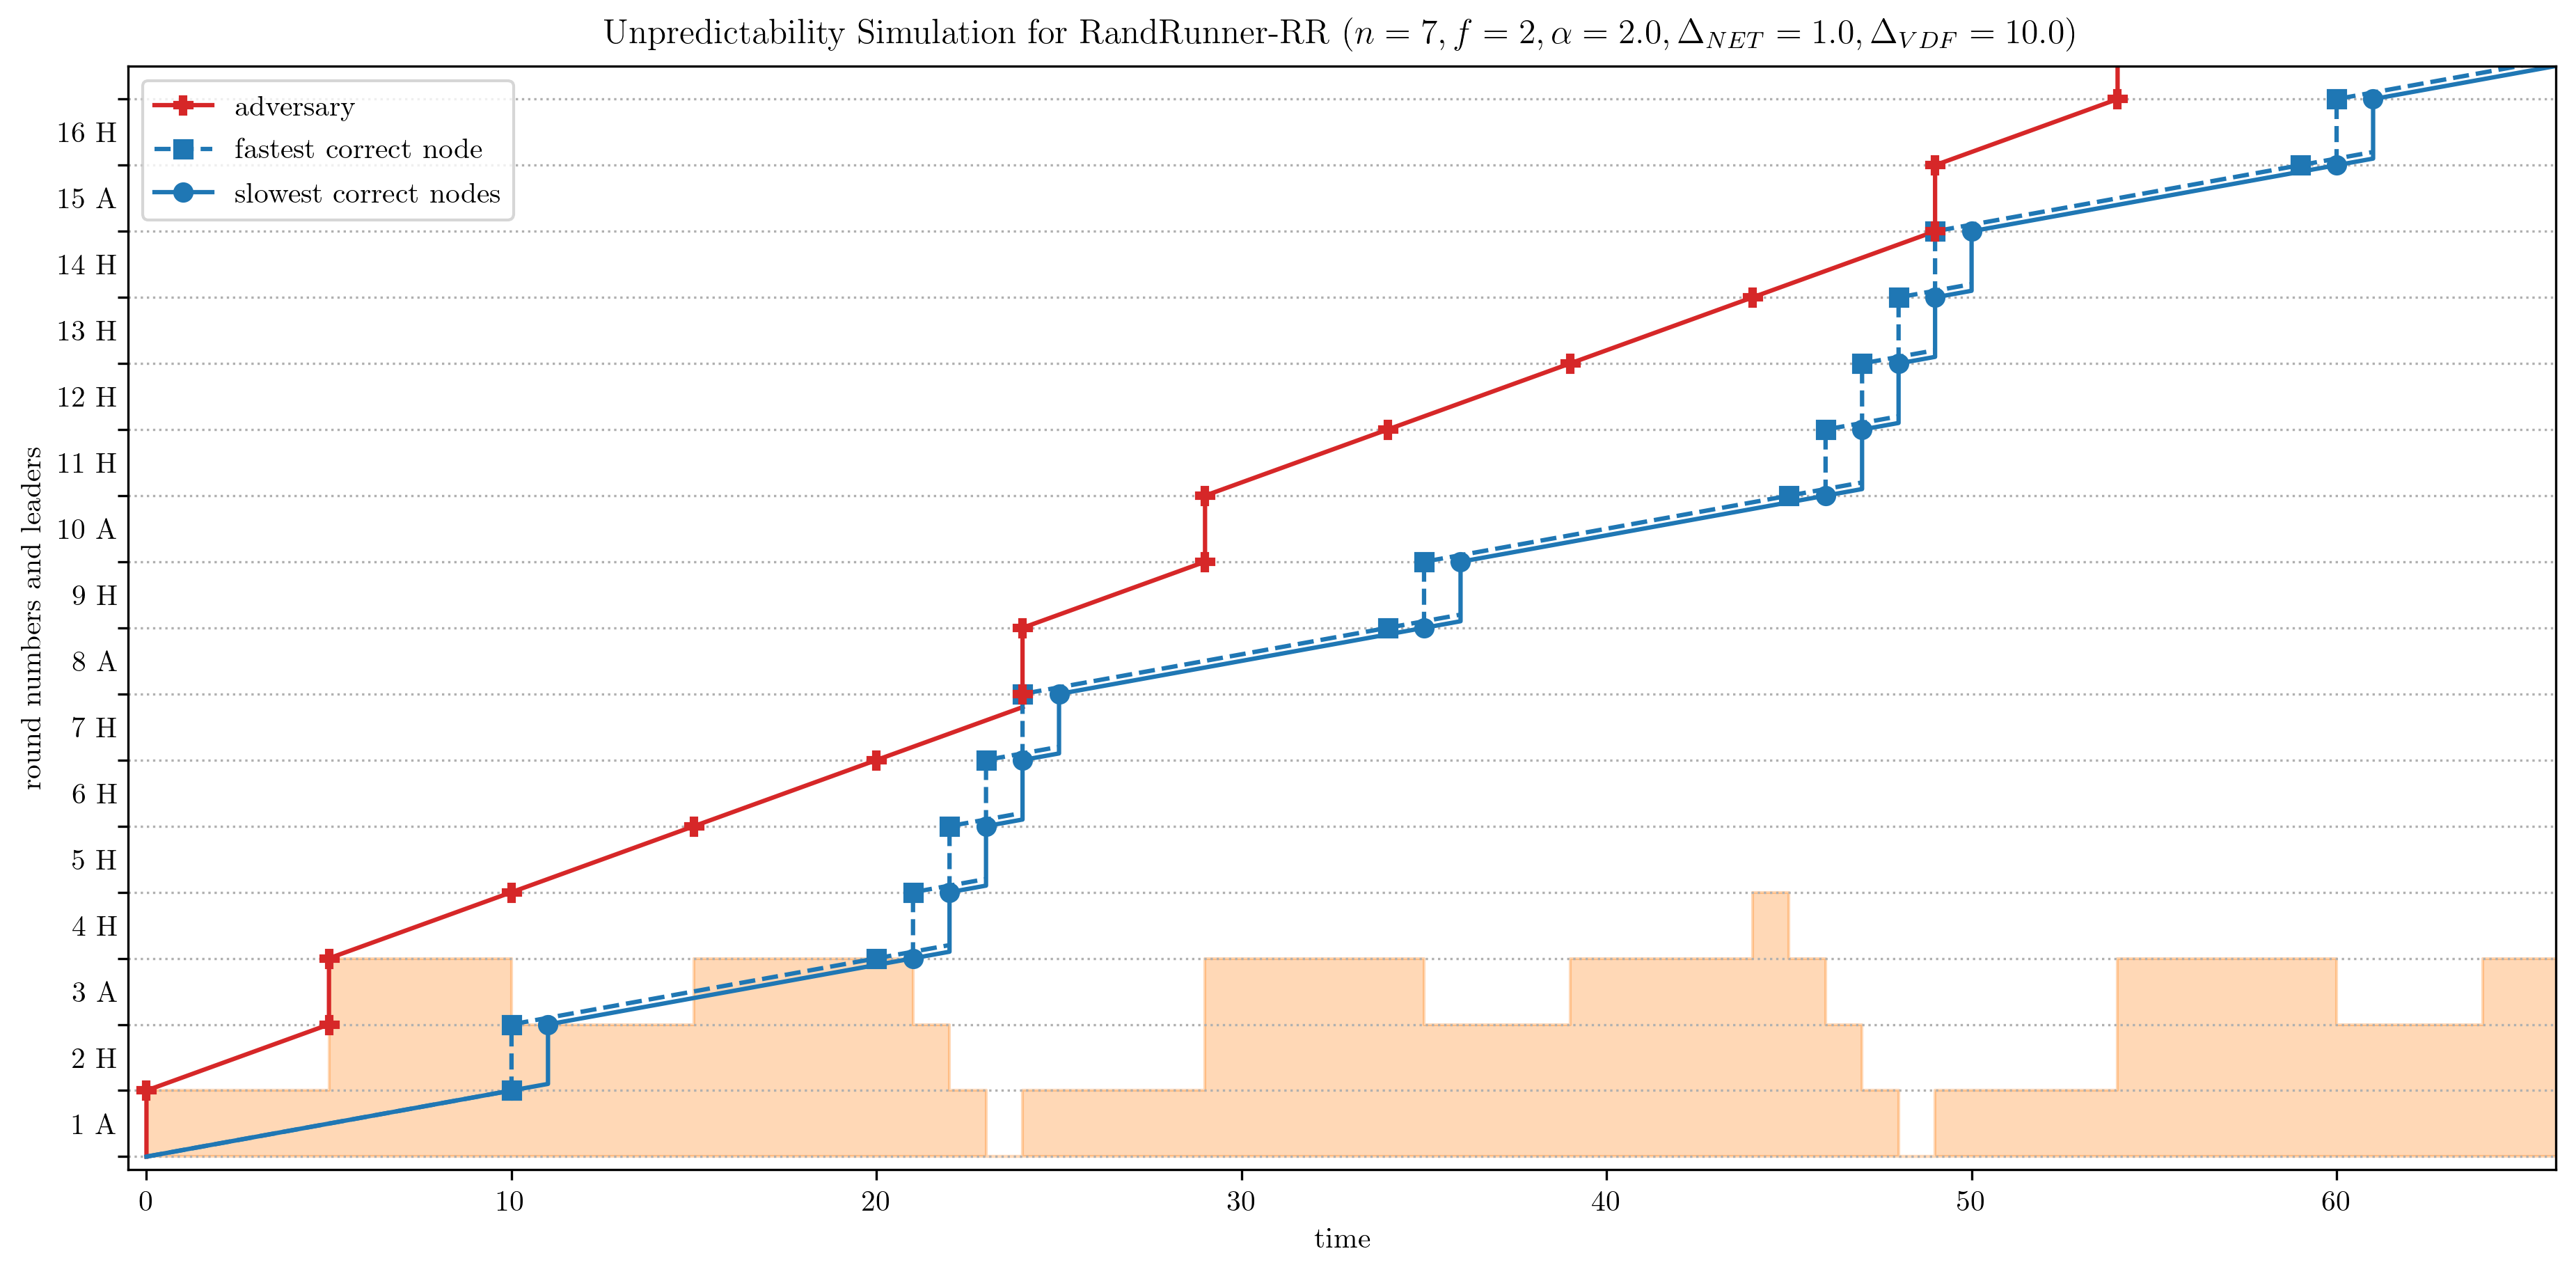

In [32]:
plot_simulation(
    alpha=2, delta_net=1, delta_vdf=10, num_rounds=16, 
    round_robin_sequence="AHA HHHH",
)

## Worst Case Scenario with Max. Consecutive Adversarial Leaders

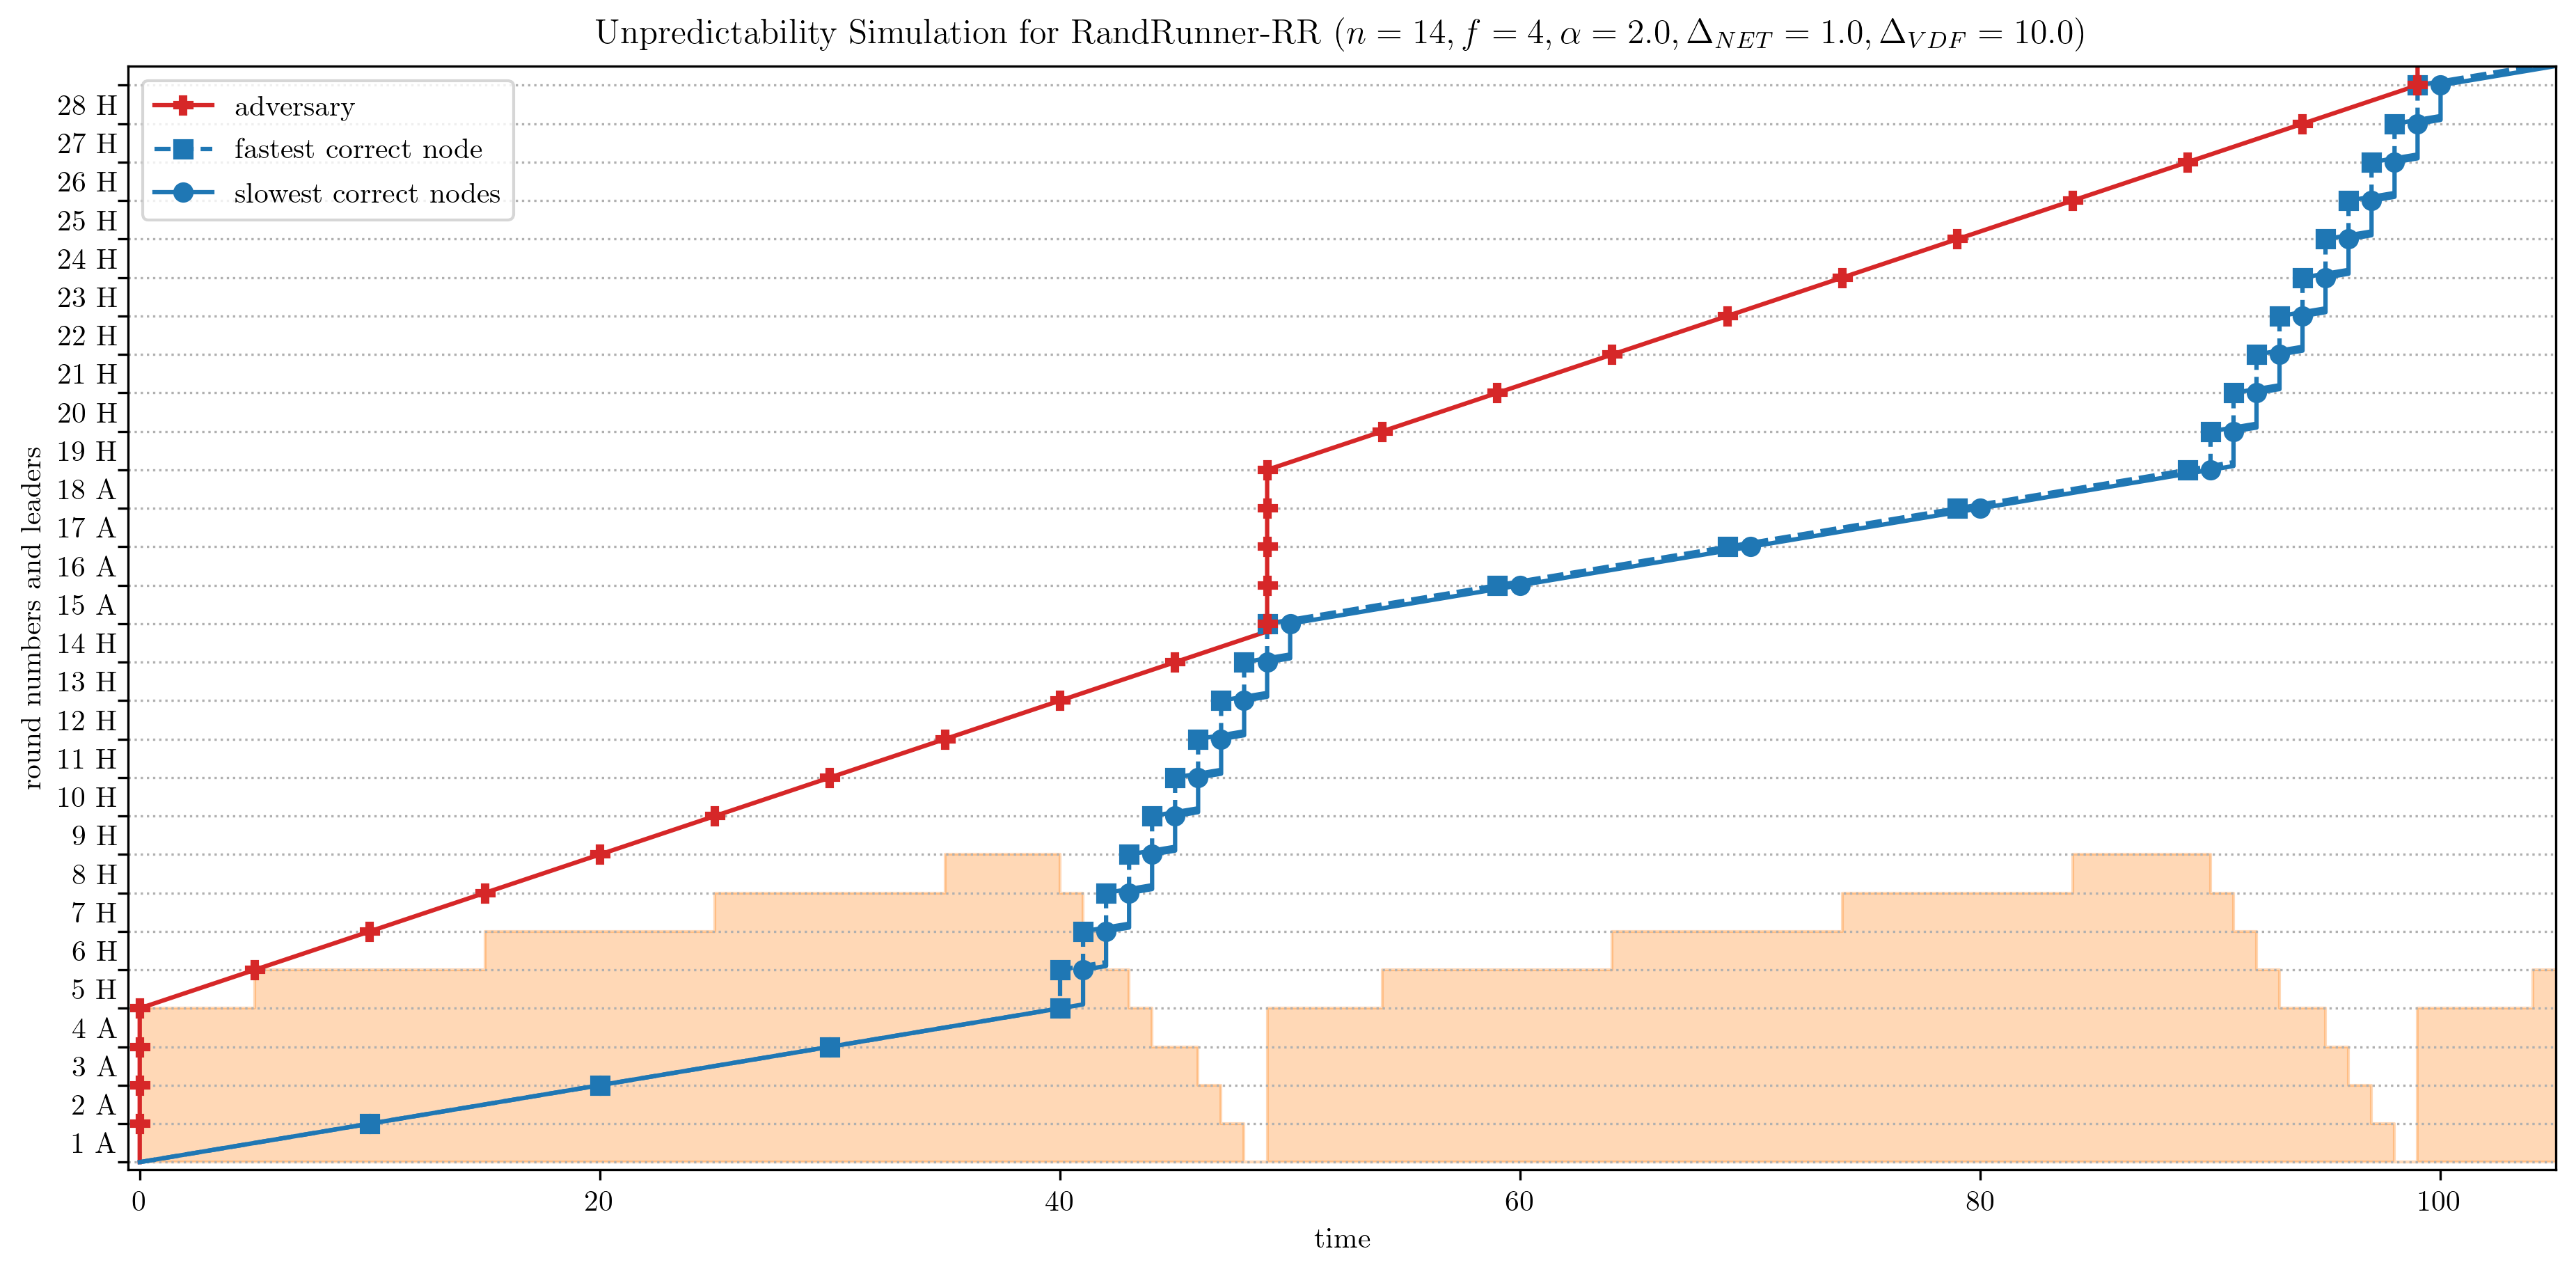

In [33]:
plot_simulation(
    alpha=2, delta_net=1, delta_vdf=10, num_rounds=14*2, 
    round_robin_sequence="AAAA HHHHH HHHHH",
)

## Covert Model with $ \alpha = 3.0 $

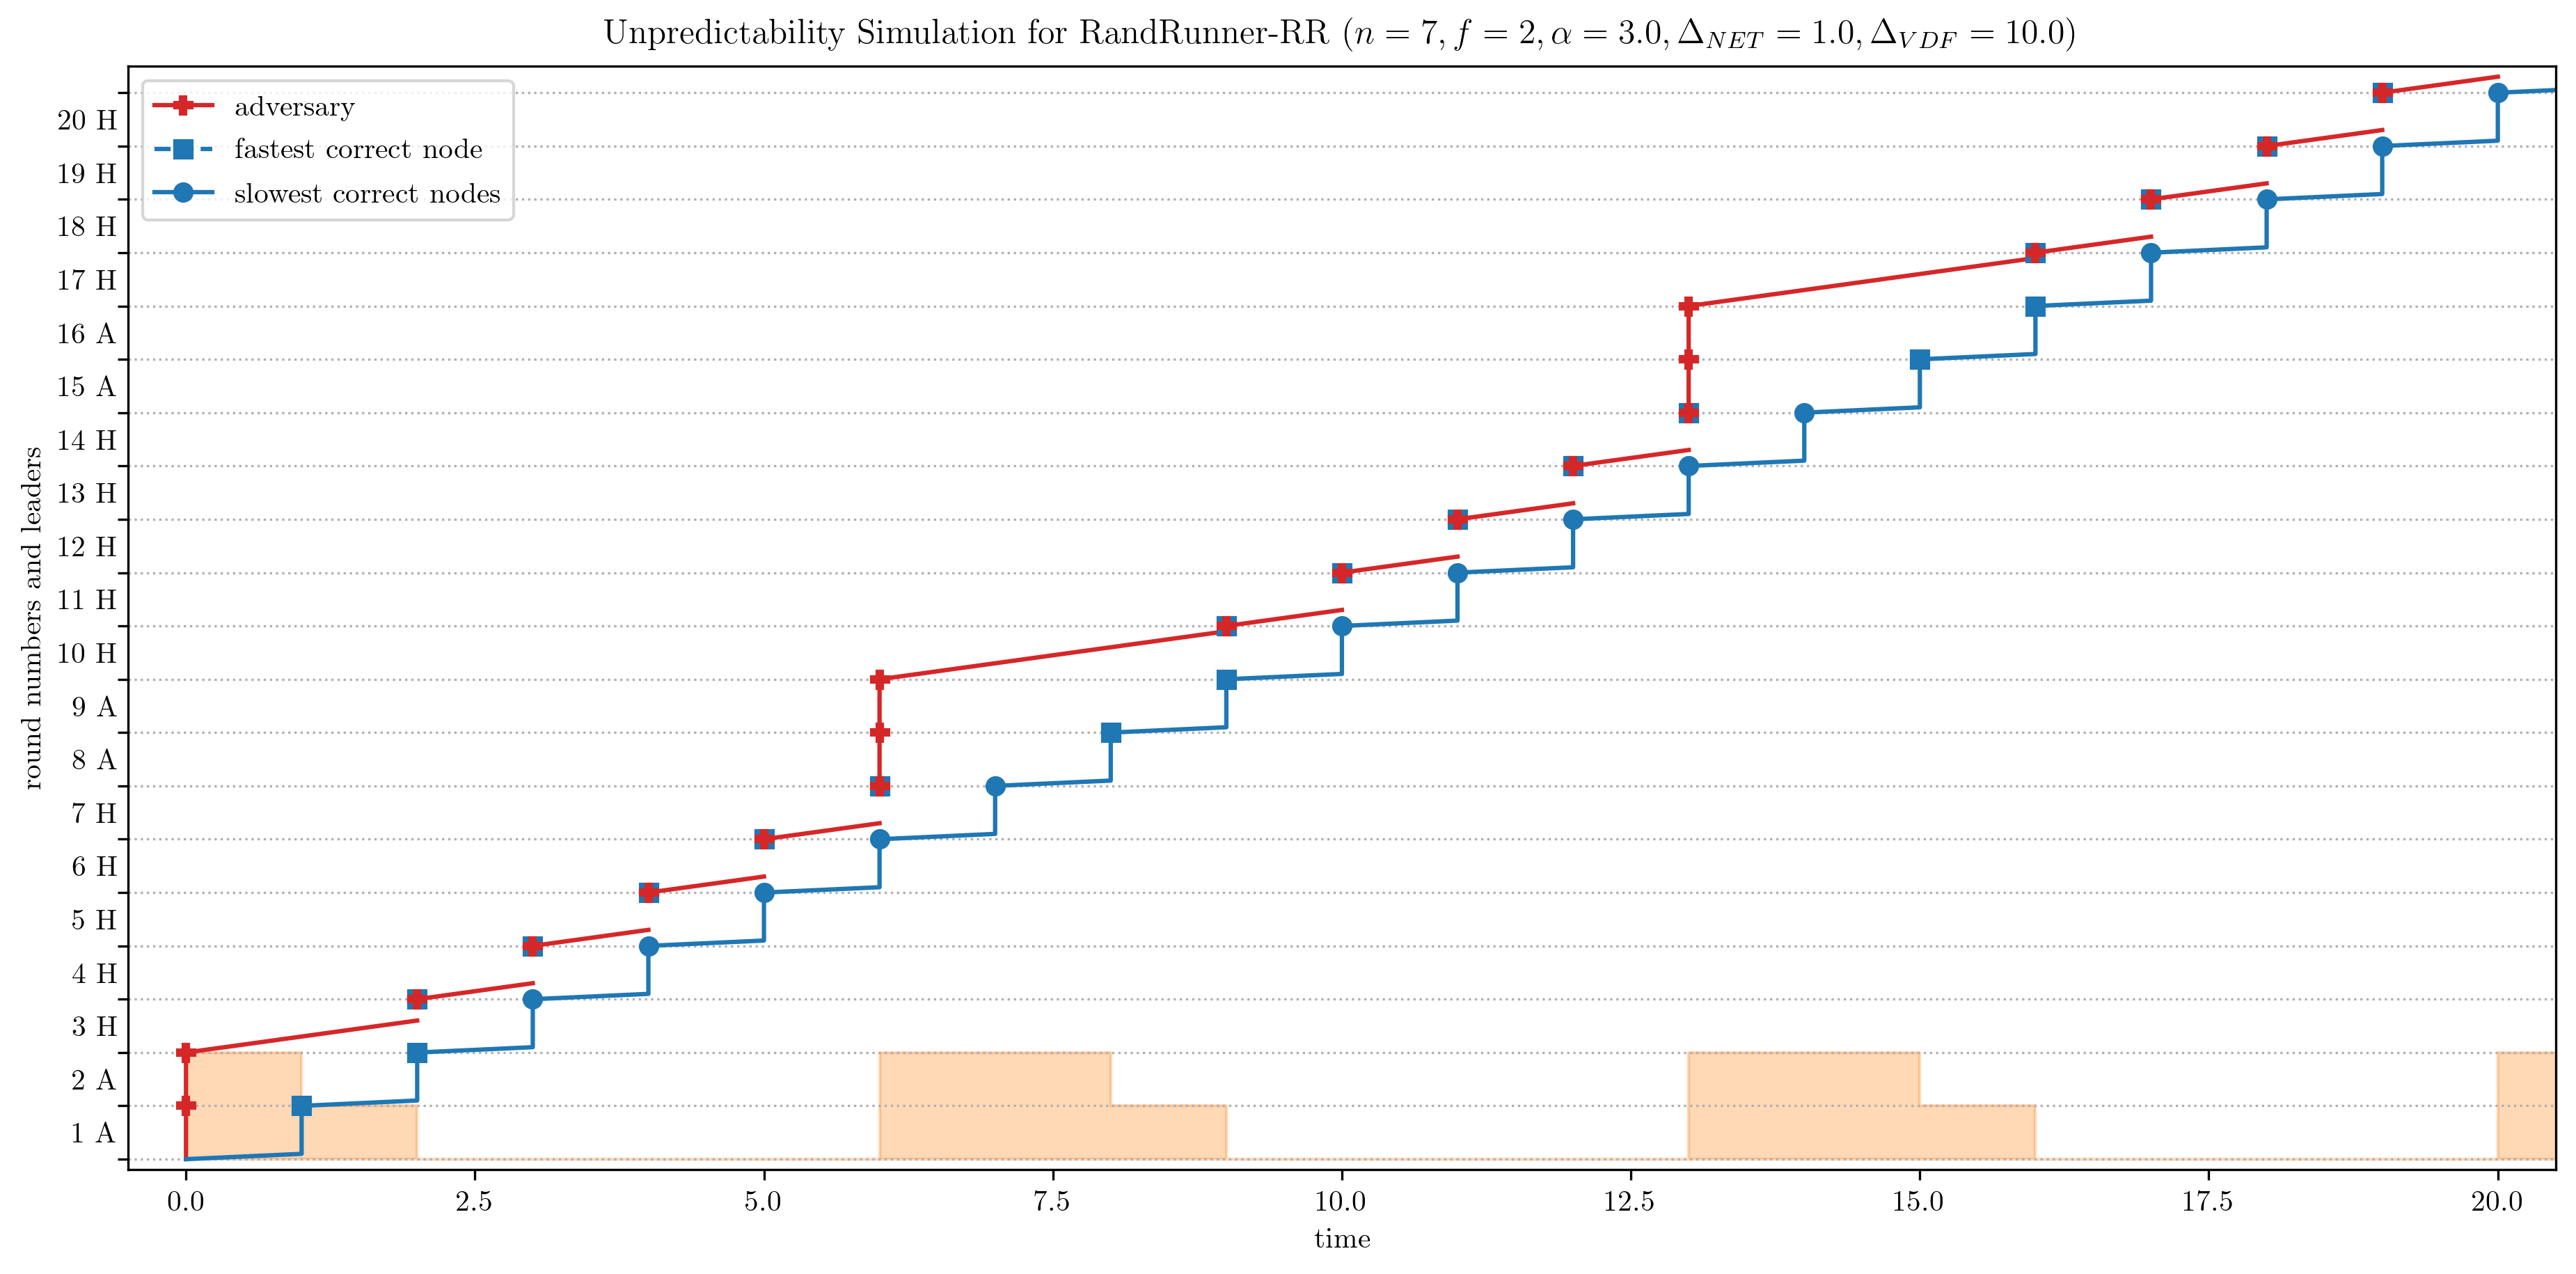

In [34]:
plot_simulation(
    alpha=3, delta_net=1, delta_vdf=10, num_rounds=20, 
    round_robin_sequence="AA HHHHH",
    covert=True
)

## Example for RandRunner-RS ($ p_A=0.33 $, $ \alpha=1.0 $)

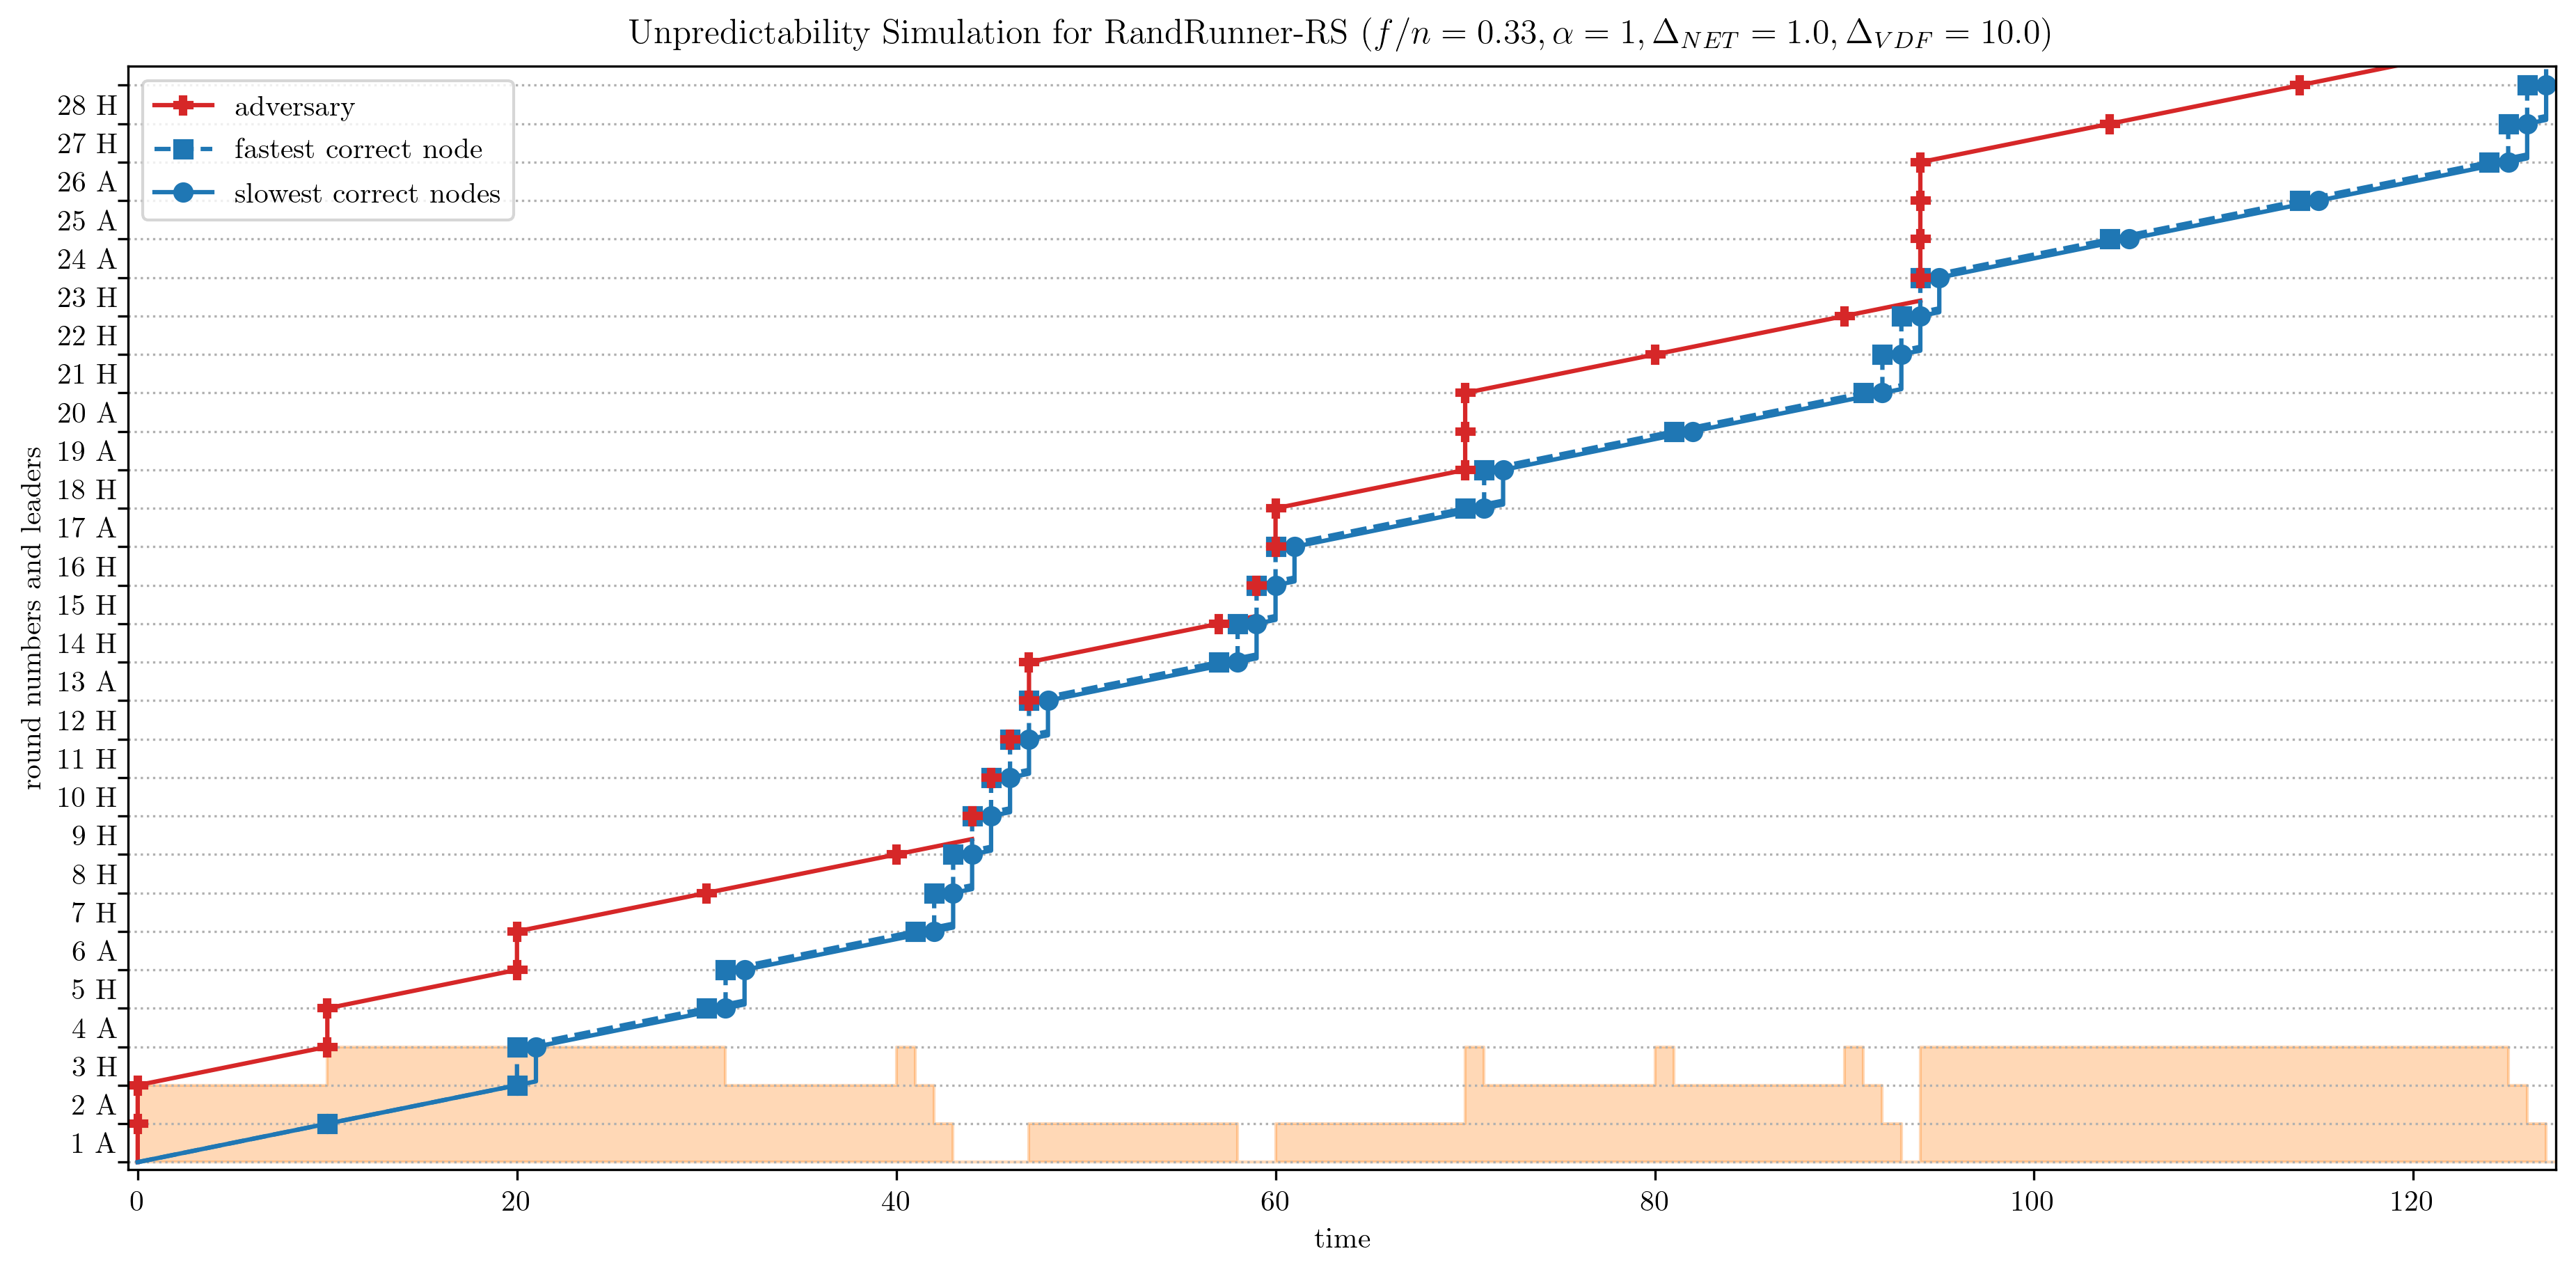

In [35]:
plot_simulation(
    pA=0.33, alpha=1, delta_net=1, delta_vdf=10, num_rounds=14*2, 
)